In [1]:
import sys
sys.path.append(r'..//')
from ioMicro import *

In [2]:
def apply_flat_field(dec,tag=r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets\med_col_raw'):
    ### load the immeds
    Icol = dec.XH_pruned[:,:,-2].astype(int)
    uIcols = np.unique(Icol)
    dec.ncols = len(uIcols)
    #save_folder=dec.save_folder#r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
    immeds = []
    for icol in range(dec.ncols):
        fl_med = tag+str(icol)+'.npz'
        if not os.path.exists(fl_med):
            fl_med = fl_med.replace('_raw','')
        dic = np.load(fl_med)
        immed,resc=dic['im'],dic['resc']
        immeds.append(immed)
    dec.immeds = np.array(immeds)
    dec.resc = resc
    
    ### renormalize the brightness according to flatfield
    XH = dec.XH_pruned
    Icol = XH[:,:,-2].astype(int)
    H = dec.XH_pruned[:,:,-3].copy()
    for icol in range(dec.ncols):
        keep = Icol==icol
        immed = dec.immeds[icol].copy()
        immed = immed/np.median(immed)
        x_,y_ = ((XH[keep][:,1:3]/dec.resc).astype(int)%immed.shape).T
        norm_ = immed[x_,y_] 
        H[keep]=H[keep]/norm_
    dec.XH_pruned[:,:,-3] = H


def main_analysisV1(fov,set_,
                   save_folder = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12',
                   save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                   save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpots',
                   drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                   segm_tag = 'A1_LamA_Nup98',redo=False,resc=[2,2,2],
                   drift_semgentation = np.array([  -2.5602207, -486.3025   ,   -5.648471 ])):


    if not os.path.exists(save_folder_all): os.makedirs(save_folder_all)
    save_fl = save_folder_all+os.sep+'saveDecodedFinalV1--'+os.path.basename(save_folder)+'--'+fov.split('.')[0]+'--'+set_+'.npz'
    dec = None
    if not os.path.exists(save_fl) or redo:
        ####### Load in the decoded spot data #############################
        #fov,set_ = 'Conv_zscan__040', '_D16' ################## Change 
        dec = decoder_simple(save_folder,fov,set_)
        dec.ncols = 3
        dec.load_decoded()
        print("Molecules size:",dec.XH_pruned.shape)
        print("Covering reaoduts:",np.unique(dec.XH_pruned[:,:,-1]))
        apply_fine_drift(dec,plt_val=True)
        apply_flat_field(dec)
        #scoresRefT = get_score_per_color(dec)
        scoresRef = np.load(save_fl_ref,allow_pickle=True)
        get_score_withRef(dec,scoresRef,plt_val=True,gene=None,iSs = None,th_min=-10)
        dec.th=-0.5
        plot_statistics(dec)

        ####### Threhold the decoded spot data #############################
        keepf =  dec.scoreA>dec.th ### keep good score
        icodesf = dec.icodesN[keepf]
        XHfpr = dec.XH_pruned[keepf]

        ### Reorganize data  ###############################
        XHf = np.mean(XHfpr,axis=1)
        XF = XHf[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
        #zc,xc,yc,bk-7,a-6,habs-5,hn-4,h-3
        XF[:,-1] = dec.scoreA[keepf]
        XF[:,-2] = np.where(keepf)[0]
        mnD = np.mean(np.linalg.norm((XHf[:,np.newaxis]-XHfpr)[:,:,:3],axis=-1),axis=-1)
        XF[:,-3]=mnD
        mnH = np.mean(np.abs((XHf[:,np.newaxis]-XHfpr)[:,:,-3]),axis=-1)
        XF[:,-4]=mnH
        genesf = dec.gns_names[icodesf]

        ### Apply drift to match the segmentation reference ########################
        def get_drft_dic(fl_all_drift):
            drft,flds,fov_,fl_ref= np.load(fl_all_drift,allow_pickle=True)
            return {('--'.join(fld.split(os.sep)[-2:]) if '--' in os.path.basename(fld) else os.path.basename(fld)):drft_[0] 
                    for fld,drft_ in zip(flds,drft)}

        fl_all_drift = drift_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
        drft_dic_all = get_drft_dic(fl_all_drift)
        fl_all_drift = save_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
        drft_dic_group = get_drft_dic(fl_all_drift)
        key_segm = [key for key in drft_dic_all if segm_tag in key][0]
        key_align = np.intersect1d(list(drft_dic_all.keys()),list(drft_dic_group.keys()))[0]
        if drift_semgentation is None:
            drift_semgentation = drft_dic_all[key_segm]
        th1_to_h0 = drift_semgentation-drft_dic_all[key_align]
        th1_gr = drft_dic_group[key_align]
        tzxyf = th1_gr+th1_to_h0

        XF[:,:3]=XF[:,:3]-tzxyf #### do not add here

        
                
        ### Load in the current fov segmentation ######################################
        ifov = fovs.index(dec.fov)
        coords= coordsf[ifov]
        xIm,xIM,yIm,yIM = coords[0],coords[1],coords[2],coords[3]
        min_ = np.min(XF[:,:3],axis=0)
        max_ = np.max(XF[:,:3],axis=0)

        xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
        ### deal with the case of outside image
        Im = np.array([xIm,yIm])
        min_[1:]=min_[1:]-Im*(Im<0)*resc[1:]
        ### recenter
        xIm,xIM,yIm,yIM = coords[0],coords[1],coords[2],coords[3]
        xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
        XF__=XF[:,:3]-min_
        xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
        dec.im_segm_ = imfsegm[:,xIm:xIM,yIm:yIM]
        dec.XF__ = XF__
        dec.XF = XF
        dec.resc = resc

        #### get cell ids #######################
        def get_cell_id(dec,Xh,resc=[2,2,2],plot_val = False):
            if not hasattr(dec,'im_segm_'): 
                good = np.ones(len(Xh),dtype=bool)
                cells_ = np.zeros(len(Xh),dtype=int)
                return cells_,good
            im_segm = dec.im_segm_
            dec.shapesm = dec.im_segm_.shape
            Xcms = Xh[:,:3]
            Xred = np.round(Xcms/resc).astype(int)
            good = ~np.any((Xred>=dec.shapesm)|(Xred<0),axis=-1)
            Xred = Xred[good]
            if plot_val:
                v = napari.view_points(Xred,size=1.5)
                v.add_labels(im_segm)
            return im_segm[tuple(Xred.T)],good


        cell_id,good =get_cell_id(dec,XF__,resc=resc,plot_val = False)
        #XF_ = np.concatenate([XF[good],cell_id[:,np.newaxis]],axis=-1)
        genesf_ = genesf[good]
        iset = int(dec.set_.split('_D')[-1])
        ifov = int(dec.fov.split('_')[-1].split('.')[0])
        isets = np.array([iset]*len(cell_id))[:,np.newaxis]
        ifovs = np.array([ifov]*len(cell_id))[:,np.newaxis]
        cell_id = cell_id[:,np.newaxis]
        XF_ = np.concatenate([XF[good],cell_id,ifovs,isets],axis=-1)

        #get_xyfov(dec)
        ### add absolute positiuons of molecules in um
        pixel_size = np.array([0.4,0.10833,0.10833])*resc
        XF_ = XF_[:,list(np.arange(XF_.shape[-1]))+[-1,-1,-1]]
        XF_[:,-3:]=((XF_[:,:3]/resc)+[0,coords[0],coords[2]])*pixel_size
        header = ['z','x','y','abs_brightness','cor','brightness','color','mean_bightness_variation','mean_distance_variation',
                  'index_from_XH_pruned','score','cell_id','ifov','iset','z_um_abs','x_um_abs','y_um_abs']


        ##### get info for cells #########################
        if not hasattr(dec,'im_segm_'): dec.im_segm_=np.zeros(np.array([30,3000,3000])//2)
        icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
        #icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))

        cells_abs_pos = (cms+[0,coords[0],coords[2]])*pixel_size

        cellinfo = cms[:,[0,0,0,1,2,0,0,0]]
        cellinfo[:,0]=icells
        cellinfo[:,1]=vols
        cellinfo[:,-3:]=cells_abs_pos

        header_cells = ['cell_id','volm','zc','xc','yc','z_um_abs','x_um_abs','y_um_abs']
        plt.close('all')

        if True:
            np.savez_compressed(save_fl,XF=XF_.astype(np.float32),
                                genes = genesf_,cellinfo=cellinfo.astype(np.float32),header_cells=header_cells,header=header)
        print("Finished",save_fl)
    return dec

In [3]:
set_ = '_D13'
dic_ = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\imfsegm--'+set_+'.npz')################
imfsegm = dic_['imfsegm']
coordsf=dic_['coordsf']
resc = dic_['resc']
dic = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\pos_um_fovs--'+set_+'.npz')##################
pos=dic['pos']
fls=dic['fls']
fovs = [os.path.basename(fl).split('--')[0]for fl in fls]
set_ = '_'+os.path.basename(fls[0]).split('--')[1].split('_')[-1]

In [4]:
save_folders = [r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12',
                r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34',
                r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2']
for fld in save_folders:
    print(os.path.exists(fld))

True
True
True
True
True
True


In [7]:
paramaters = [(fov,set_,save_folder)for fov in fovs for save_folder in save_folders]
len(paramaters)

1146

In [15]:
fov,set_,save_folder = paramaters[1000]
main_analysisV1(fov,set_,
                       save_folder = save_folder,
                       save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                       save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                       drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                       segm_tag = 'A1_LamA_Nup98')

Loaded decoded: -3.09335994720459
Molecules size: (2394170, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  8.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__166--_D14.npz


In [9]:
 paramaters[1000]

('Conv_zscan__166',
 '_D13',
 '\\\\192.168.0.7\\bbfishmahsa3\\CGBB_embryo_4_28_2023\\MERFISH_AnalysisP711')

Loaded decoded: -3.2931435108184814
Molecules size: (2402610, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.50it/s]


Failed!!! Conv_zscan__004 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -3.3112714290618896
Molecules size: (2418933, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.80it/s]


Failed!!! Conv_zscan__005 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.08429980278015137
Molecules size: (3567, 4, 10)
Covering reaoduts: [21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1687.37it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,

Failed!!! Conv_zscan__028 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.08133745193481445
Molecules size: (2600, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 38.]


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1507.50it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([

Failed!!! Conv_zscan__028 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.08000302314758301
Molecules size: (9443, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   9.5 10.5 11.5 21.  22.  23.  24.  25.
 26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.
 40.  41.  42.  43.  44.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 730.70it/s]

Failed!!! Conv_zscan__041 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12


Loaded decoded: -0.09602475166320801
Molecules size: (17216, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 33. 34. 35. 36. 38. 39.
 41.]


100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 513.81it/s]

Failed!!! Conv_zscan__041 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.09659194946289062
Molecules size: (16197, 4, 10)


Covering reaoduts: [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 39. 40. 41. 45. 46. 47.]


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 535.71it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__041 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.04798460006713867
Molecules size: (413, 4, 10)
Covering reaoduts: [ 1.   2.   4.   5.   6.   7.   8.   9.  10.  10.5 11.  11.5 12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 5749.22it/s]


Failed!!! Conv_zscan__042 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.040006160736083984
Molecules size: (48, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   9.  10.  11.  12.  13.  15.
 16.  19.  20.  22.  23.  25.  26.  28.  28.5 29.  29.5 30.  30.5 31.
 32.5 33.  34.  34.5 35.  36.  37.  38.  39.  39.5 40.5 41.  41.5 42.5
 44.5 45.  45.5 46.5 47. ]


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 4624.51it/s]


Failed!!! Conv_zscan__042 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.0640096664428711
Molecules size: (1574, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 33. 34. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 2749.54it/s]


Failed!!! Conv_zscan__042 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.02400374412536621
Molecules size: (102, 4, 10)
Covering reaoduts: [ 1.  4.  7. 10. 12. 13. 14. 15. 16. 17. 18. 19. 20. 24. 25. 26. 27. 28.
 29. 30. 31. 32. 33. 34. 35. 37. 45. 46.]


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 3499.32it/s]

Failed!!! Conv_zscan__042 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711


Failed!!! Conv_zscan__045 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.12001872062683105
Molecules size: (62793, 4, 10)
Covering reaoduts: [ 3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.  11.5 12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 153.37it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__062 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.1189124584197998
Molecules size: (31210, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 35.]


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 221.12it/s]
C:\Scripts\NMERFISH\ioMicro.py:2463: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Failed!!! Conv_zscan__092 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.1520233154296875
Molecules size: (55325, 4, 10)
Covering reaoduts: [ 0.5  1.5  2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.
  8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.
 22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.
 29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.  37.  38.  40.
 41.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 274.96it/s]


Failed!!! Conv_zscan__092 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.1860339641571045
Molecules size: (95447, 4, 10)
Covering reaoduts: [ 0.  1.  2.  6.  7.  8.  9. 10. 11. 12. 13. 14. 21. 22. 23. 24. 25. 26.
 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]


100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 105.08it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__095 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.10501623153686523
Molecules size: (40657, 4, 10)
Covering reaoduts: [ 3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  33.  35.  38.  41. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.11it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__095 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.14483213424682617
Molecules size: (59719, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  40.  41.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 243.92it/s]


Failed!!! Conv_zscan__095 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.06455421447753906
Molecules size: (1270, 4, 10)
Covering reaoduts: [13. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2711.51it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([

Failed!!! Conv_zscan__099 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.027980327606201172
Molecules size: (189, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 33.  34.  34.5 35.  35.5 36.
 37.  37.5 38.  39.5 40.5 41.5 42.  42.5 43.5 44.5 45.  45.5 46.  46.5
 47.  47.5]


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 5755.22it/s]


Failed!!! Conv_zscan__099 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.06827354431152344
Molecules size: (997, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  31.  32.  33.  34.  35.  36.  37.  38.  40.
 41.  43.  44.  45.  46.  47. ]


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 2874.39it/s]

Failed!!! Conv_zscan__099 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2


Loaded decoded: -0.06400942802429199
Molecules size: (1430, 4, 10)
Covering reaoduts: [21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 3374.94it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,

Failed!!! Conv_zscan__109 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.03200387954711914
Molecules size: (257, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23.]


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2624.33it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,

Failed!!! Conv_zscan__109 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.09434342384338379
Molecules size: (7163, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 42. 43.]


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1416.49it/s]


Failed!!! Conv_zscan__109 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.03200411796569824
Molecules size: (377, 4, 10)
Covering reaoduts: [ 0.  1.  2.  6.  7.  8. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 35. 39.]


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 3624.18it/s]

Failed!!! Conv_zscan__109 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711


Loaded decoded: -0.04000544548034668
Molecules size: (421, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.
 21.5 22.  22.5 23.  23.5 24.  25.  25.5 26.  26.5 27.  27.5 28.  28.5
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  40.  41.  45.  46. ]


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 5123.69it/s]


Failed!!! Conv_zscan__109 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.07201194763183594
Molecules size: (4122, 4, 10)
Covering reaoduts: [ 9.5 10.5 11.5 15.  16.  17.  21.  22.  23.  24.  25.  26.  27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1291.45it/s]


Failed!!! Conv_zscan__113 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.09601378440856934
Molecules size: (23252, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44.]


100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 392.80it/s]


Failed!!! Conv_zscan__113 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.01600337028503418
Molecules size: (193, 4, 10)
Covering reaoduts: [15. 16. 17. 18. 19. 20. 21. 22. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.
 34. 35. 43.]


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2624.49it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__113 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.04800724983215332
Molecules size: (879, 4, 10)
Covering reaoduts: [ 0.5  1.5  2.5  3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5
 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 30.  31.  33.  34.
 36.  37.  40.  45.  46. ]


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 4624.51it/s]


Failed!!! Conv_zscan__113 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.024004220962524414
Molecules size: (88, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  21.  22.  23.  25.  27.  28.  29.  29.5
 30.  31.  32.  34. ]


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2749.54it/s]


Failed!!! Conv_zscan__120 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.0640099048614502
Molecules size: (4688, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 42. 44. 46. 47.]


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 1583.12it/s]


Failed!!! Conv_zscan__120 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.05600905418395996
Molecules size: (331, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   3.   3.5  4.   4.5  5.   6.   6.5  7.   7.5
  8.   9.   9.5 10.  10.5 11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  22.  22.5 23.
 23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  30.  31.  33.  34.
 36.  37.  40.  45.  46. ]


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 4374.53it/s]


Failed!!! Conv_zscan__120 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.024003267288208008
Molecules size: (70, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13. 14. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 34. 35. 37. 38. 40.
 41. 43. 44. 46. 47.]


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 5124.30it/s]

Failed!!! Conv_zscan__122 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12


Loaded decoded: -0.04000592231750488
Molecules size: (24, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 25.]


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2874.35it/s]

Failed!!! Conv_zscan__122 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34


Loaded decoded: -0.048006296157836914
Molecules size: (5, 4, 10)
Covering reaoduts: [ 0.   6.  10.  12.  15.  16.  22.  26.  28.  29.  34.  35.  37.  38.
 43.5]


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1499.62it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Failed!!! Conv_zscan__122 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.032004356384277344
Molecules size: (115, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 34. 35. 44.]


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3749.04it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Failed!!! Conv_zscan__122 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.026241540908813477
Molecules size: (4, 4, 10)
Covering reaoduts: [ 0.  3.  6.  9. 12. 15. 18. 21. 27. 30.]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Failed!!! Conv_zscan__122 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.016379833221435547
Molecules size: (14, 4, 10)
Covering reaoduts: [ 0.   1.   3.   4.   4.5  5.   6.   7.   8.   9.   9.5 10.  13.  15.5
 17.  19.  24.  26.  34.  40. ]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<?, ?it/s]


Failed!!! Conv_zscan__122 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.16800427436828613
Molecules size: (153627, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  27.
 28.  29.  30.  32.  36.  38.  39.  41. ]


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 43.89it/s]


Failed!!! Conv_zscan__127 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.15200591087341309
Molecules size: (96280, 4, 10)
Covering reaoduts: [ 3.  4.  5. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26.
 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]


100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 128.27it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__127 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.3860630989074707
Molecules size: (306469, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  42.  43.  44.
 45.  46.  47. ]


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 30.64it/s]


Failed!!! Conv_zscan__164 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.07035303115844727
Molecules size: (2022, 4, 10)
Covering reaoduts: [ 3.  4. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1748.95it/s]


Failed!!! Conv_zscan__165 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.0399937629699707
Molecules size: (2278, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 38.]


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2624.41it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__165 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.05638742446899414
Molecules size: (1318, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.
 42. 43. 44. 45. 46. 47.]


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 5249.75it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__165 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.08351755142211914
Molecules size: (1759, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  30.  30.5 31.  31.5 33.  34.  36.  37.  38.  40.  41.
 45.  46. ]


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 2376.06it/s]


Failed!!! Conv_zscan__165 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.1200101375579834
Molecules size: (57956, 4, 10)
Covering reaoduts: [ 9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.  16.  17.  18.  19.
 20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
 34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 180.53it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__168 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.09463834762573242
Molecules size: (22291, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 30. 32. 39. 41. 42. 44. 45. 47.]


100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 258.91it/s]


Failed!!! Conv_zscan__168 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.0640096664428711
Molecules size: (15701, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5
 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  30.  30.5 31.
 31.5 32.  32.5 33.  34.  35.  36.  37.  38.  40.  41.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 999.85it/s]


Failed!!! Conv_zscan__168 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.6225771903991699
Molecules size: (517673, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.93it/s]


Failed!!! Conv_zscan__183 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711


C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


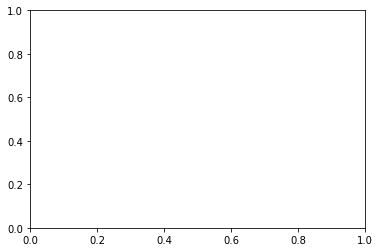

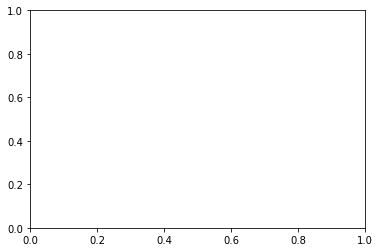

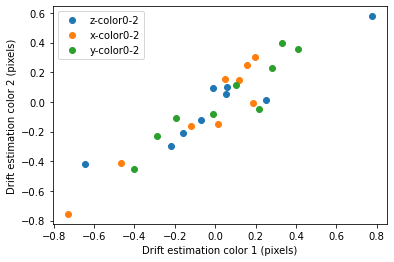

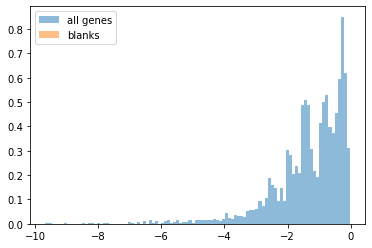

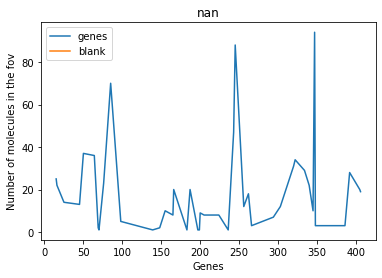

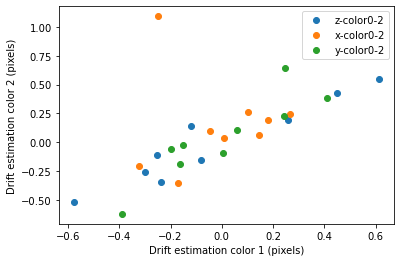

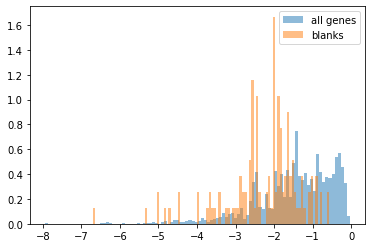

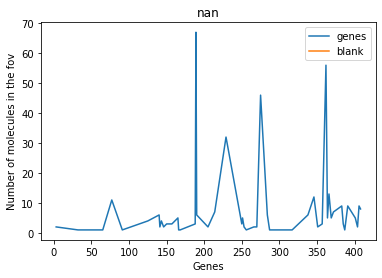

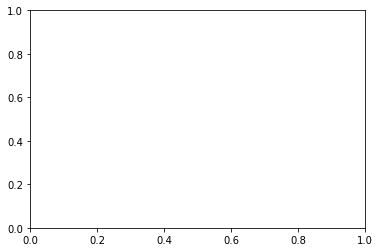

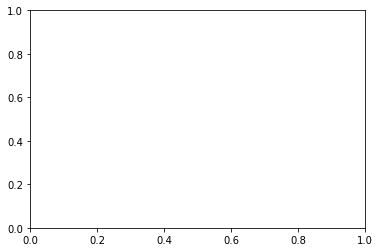

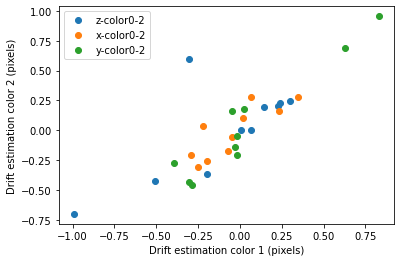

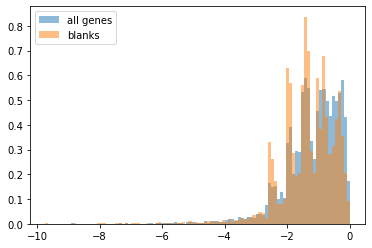

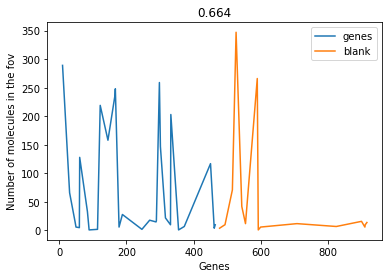

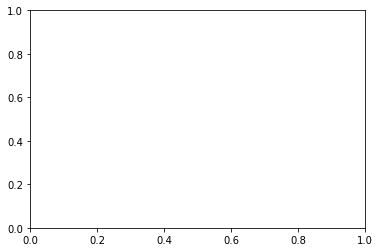

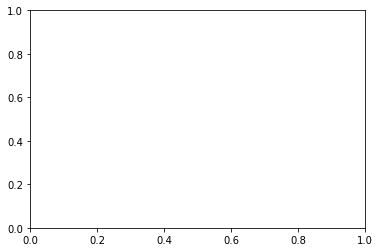

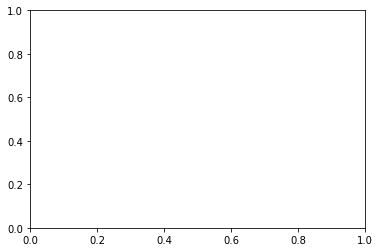

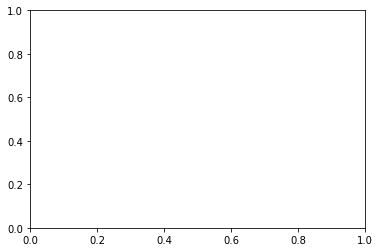

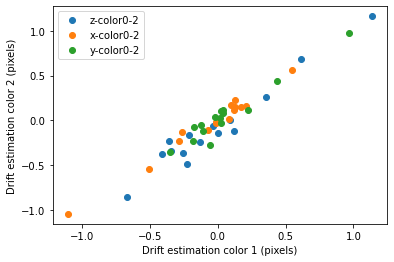

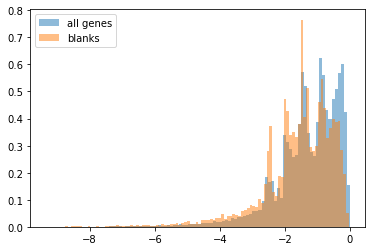

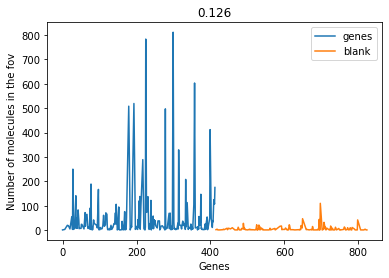

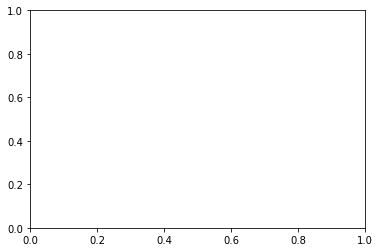

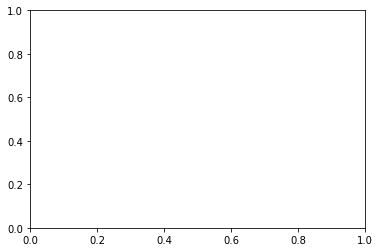

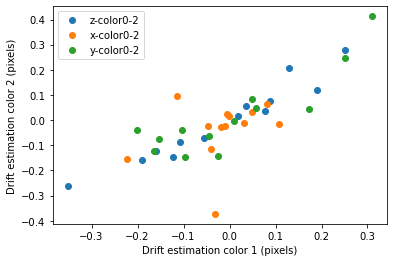

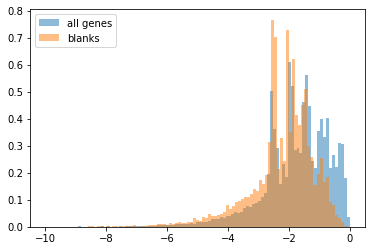

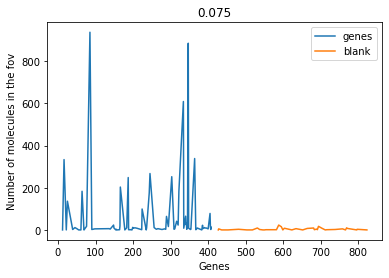

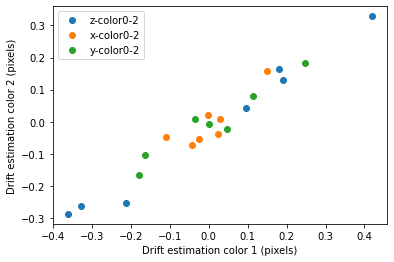

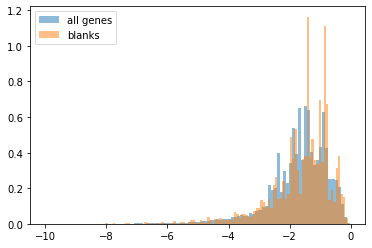

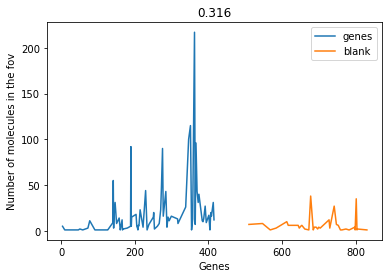

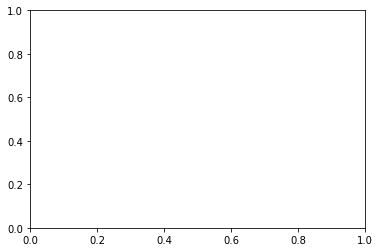

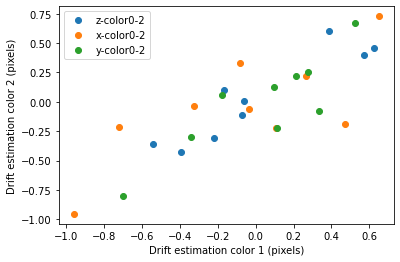

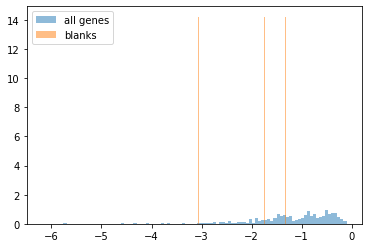

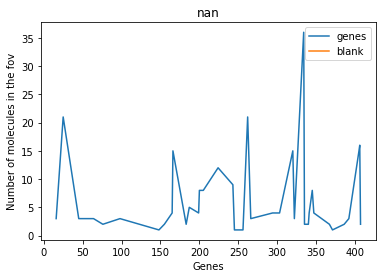

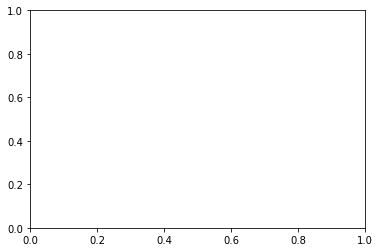

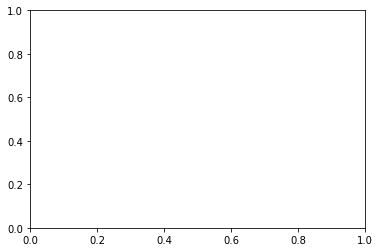

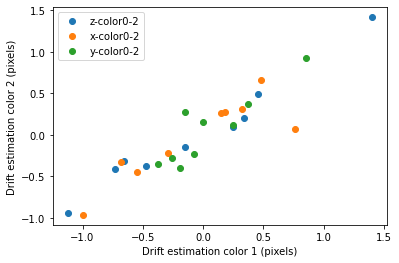

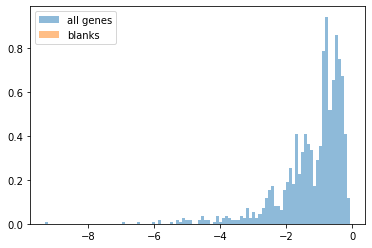

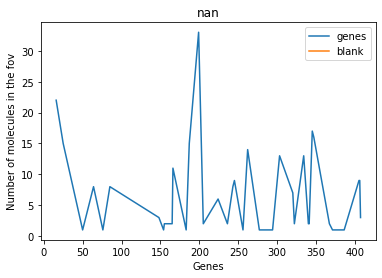

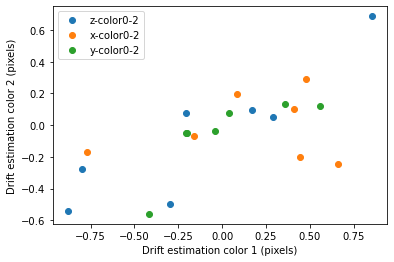

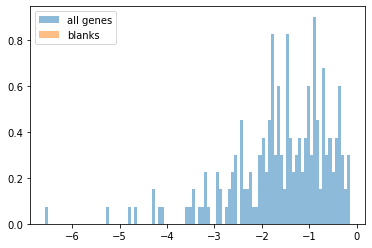

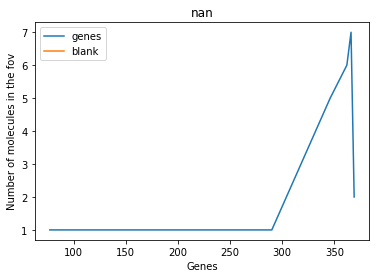

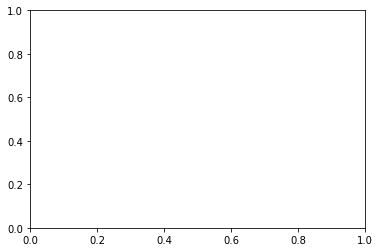

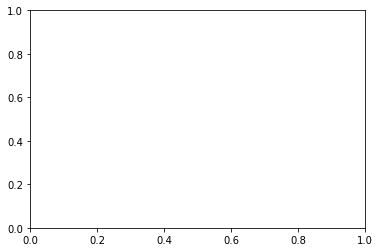

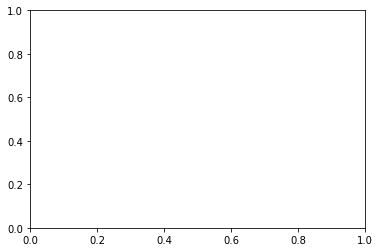

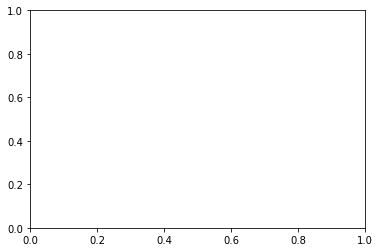

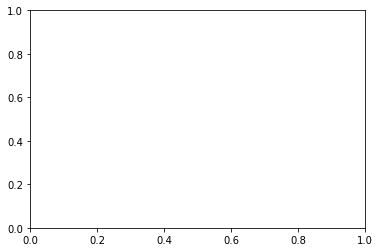

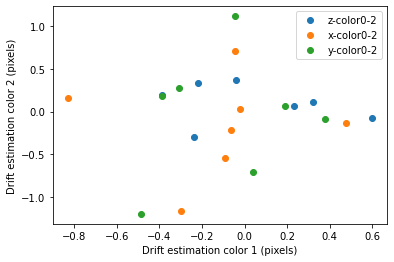

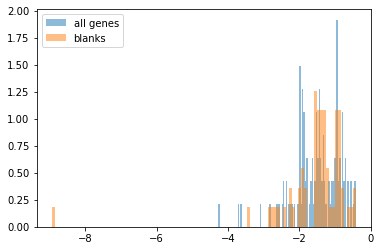

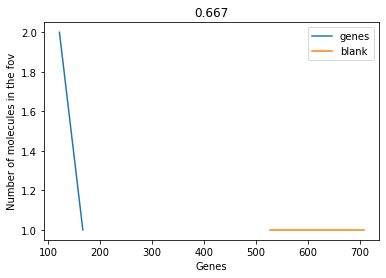

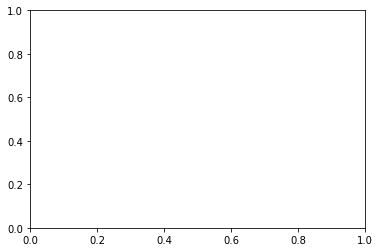

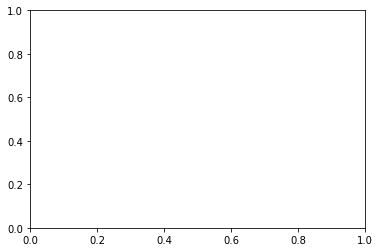

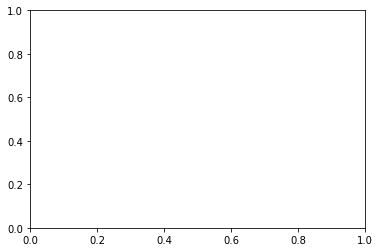

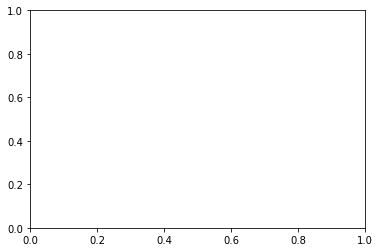

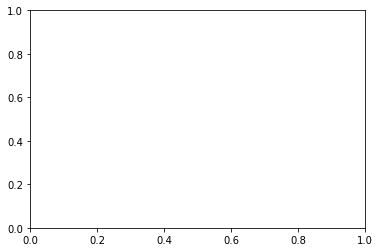

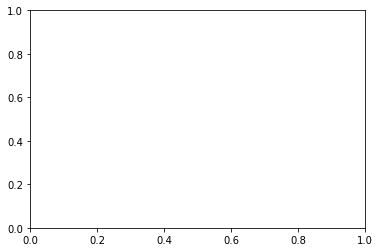

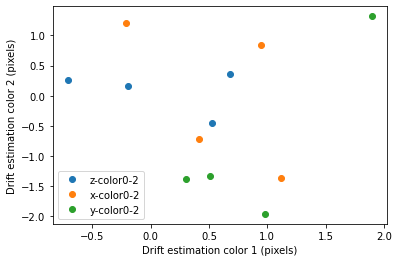

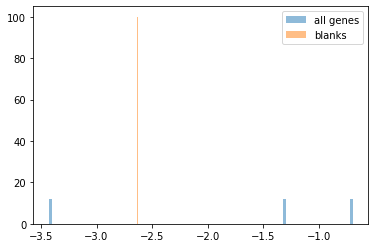

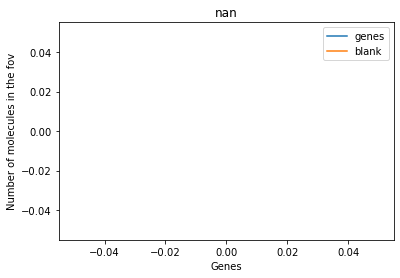

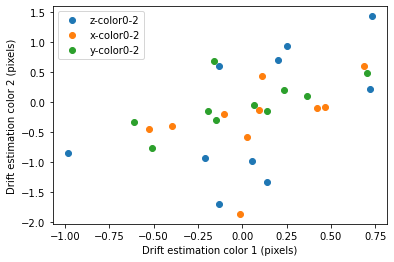

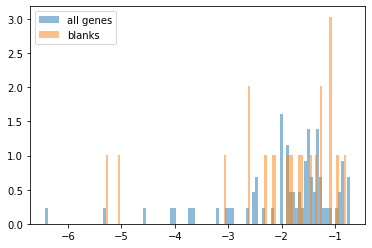

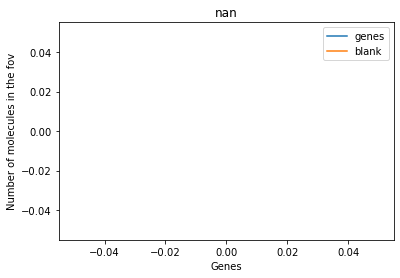

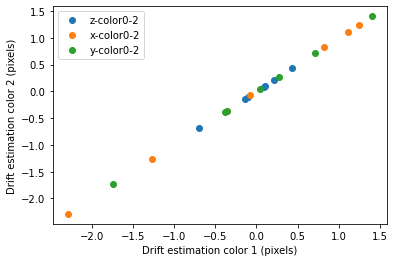

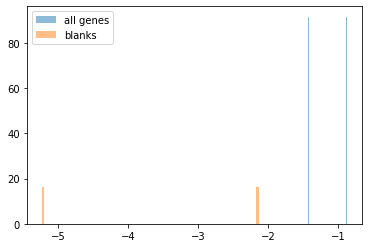

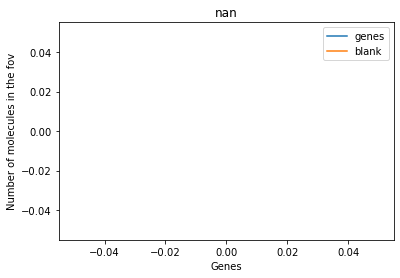

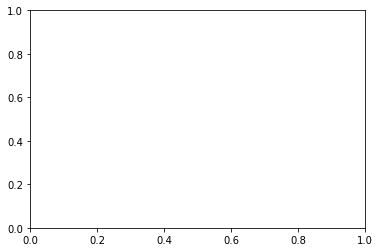

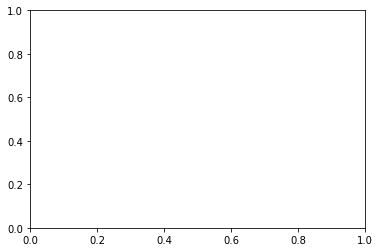

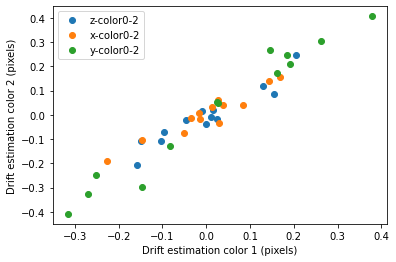

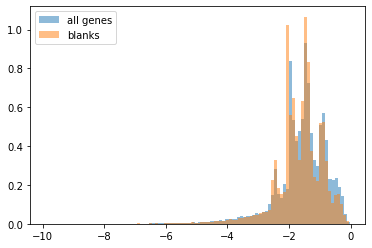

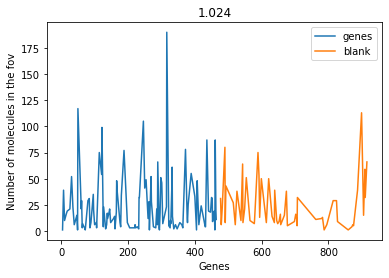

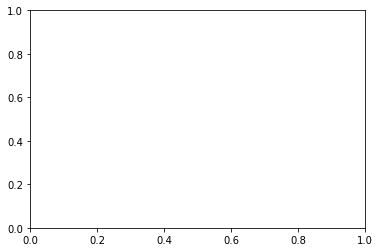

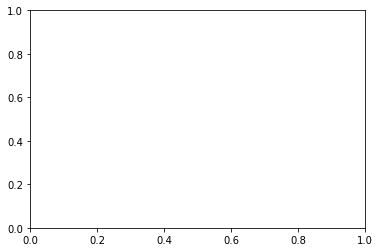

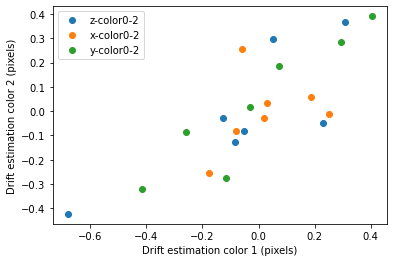

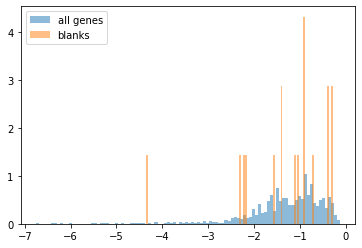

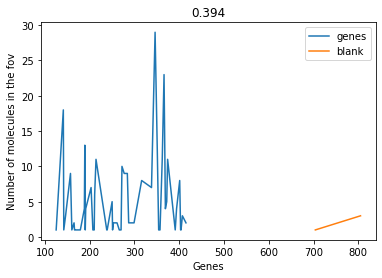

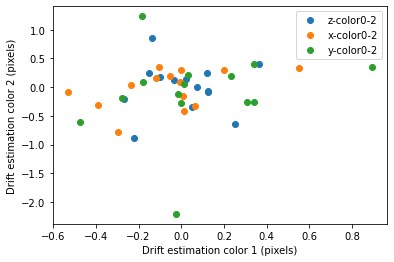

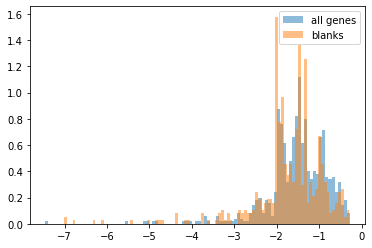

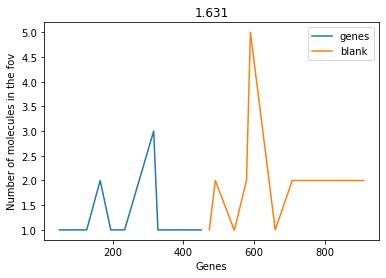

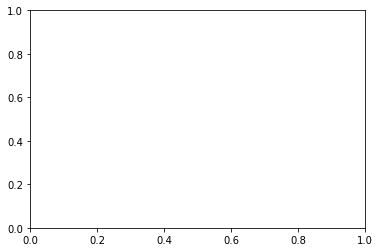

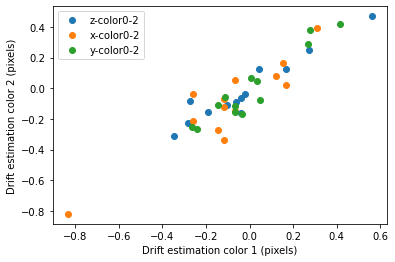

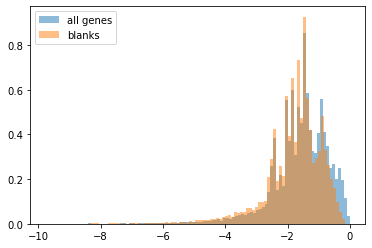

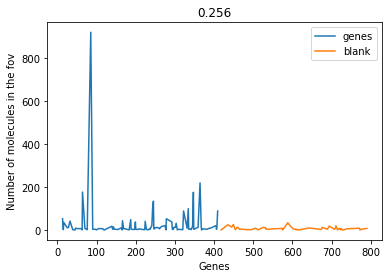

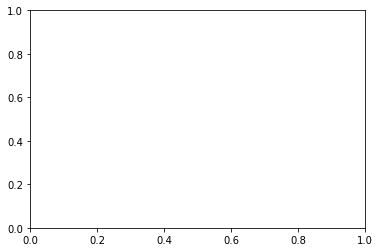

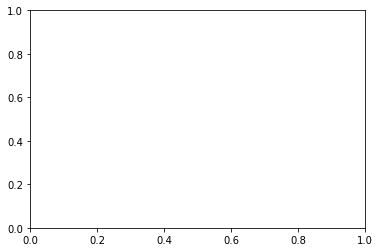

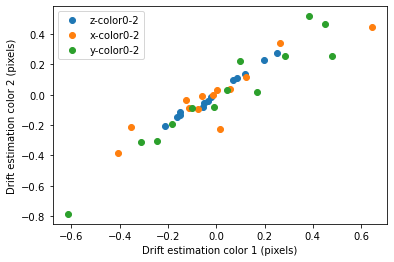

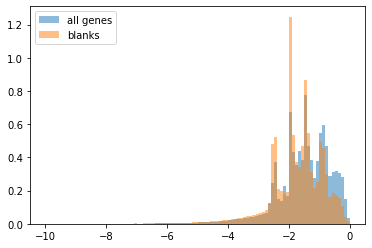

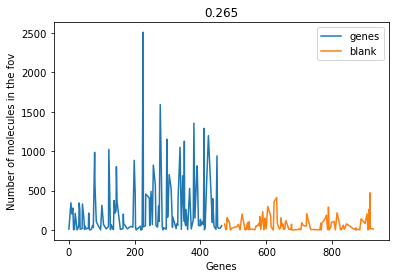

In [8]:
parms__ = [('Conv_zscan__004', '_D13', 'MERFISH_AnalysisE1'), ('Conv_zscan__005', '_D13', 'MERFISH_AnalysisE1'), ('Conv_zscan__028', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__028', '_D13', 'MERFISH_AnalysisP34'), ('Conv_zscan__041', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__041', '_D13', 'MERFISH_AnalysisP34'), ('Conv_zscan__041', '_D13', 'MERFISH_AnalysisP711'), ('Conv_zscan__042', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__042', '_D13', 'MERFISH_AnalysisE1'), ('Conv_zscan__042', '_D13', 'MERFISH_AnalysisP56'), ('Conv_zscan__042', '_D13', 'MERFISH_AnalysisP711'), ('Conv_zscan__045', '_D13', 'MERFISH_AnalysisP56'), ('Conv_zscan__062', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__092', '_D13', 'MERFISH_AnalysisP711'), ('Conv_zscan__092', '_D13', 'MERFISH_AnalysisE2'), ('Conv_zscan__095', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__095', '_D13', 'MERFISH_AnalysisP34'), ('Conv_zscan__095', '_D13', 'MERFISH_AnalysisE2'), ('Conv_zscan__099', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__099', '_D13', 'MERFISH_AnalysisE1'), ('Conv_zscan__099', '_D13', 'MERFISH_AnalysisE2'), ('Conv_zscan__109', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__109', '_D13', 'MERFISH_AnalysisP34'), ('Conv_zscan__109', '_D13', 'MERFISH_AnalysisP56'), ('Conv_zscan__109', '_D13', 'MERFISH_AnalysisP711'), ('Conv_zscan__109', '_D13', 'MERFISH_AnalysisE2'), ('Conv_zscan__113', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__113', '_D13', 'MERFISH_AnalysisP56'), ('Conv_zscan__113', '_D13', 'MERFISH_AnalysisP711'), ('Conv_zscan__113', '_D13', 'MERFISH_AnalysisE2'), ('Conv_zscan__120', '_D13', 'MERFISH_AnalysisE1'), ('Conv_zscan__120', '_D13', 'MERFISH_AnalysisP711'), ('Conv_zscan__120', '_D13', 'MERFISH_AnalysisE2'), ('Conv_zscan__122', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__122', '_D13', 'MERFISH_AnalysisP34'), ('Conv_zscan__122', '_D13', 'MERFISH_AnalysisE1'), ('Conv_zscan__122', '_D13', 'MERFISH_AnalysisP56'), ('Conv_zscan__122', '_D13', 'MERFISH_AnalysisP711'), ('Conv_zscan__122', '_D13', 'MERFISH_AnalysisE2'), ('Conv_zscan__127', '_D13', 'MERFISH_AnalysisP34'), ('Conv_zscan__127', '_D13', 'MERFISH_AnalysisP711'), ('Conv_zscan__164', '_D13', 'MERFISH_AnalysisP34'), ('Conv_zscan__165', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__165', '_D13', 'MERFISH_AnalysisP34'), ('Conv_zscan__165', '_D13', 'MERFISH_AnalysisP711'), ('Conv_zscan__165', '_D13', 'MERFISH_AnalysisE2'), ('Conv_zscan__168', '_D13', 'MERFISH_AnalysisP12'), ('Conv_zscan__168', '_D13', 'MERFISH_AnalysisP34'), ('Conv_zscan__168', '_D13', 'MERFISH_AnalysisE2'), ('Conv_zscan__183', '_D13', 'MERFISH_AnalysisP711')]
for fov,set_,save_folder in parms__:
    save_folder = {os.path.basename(fld):fld for fld in save_folders}[save_folder]
    try:
        main_analysisV1(fov,set_,
                               save_folder = save_folder,
                               save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                               save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                               drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                               segm_tag = 'A1_LamA_Nup98',redo=False)
    except:
        print("Failed!!!",fov,set_,save_folder)

  0%|                                                                                         | 0/1146 [00:00<?, ?it/s]

Loaded decoded: -8.266287803649902
Molecules size: (5144338, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.40it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__190--_D13.npz


  0%|                                                                              | 1/1146 [01:07<21:37:33, 67.99s/it]

Loaded decoded: -18.920512437820435
Molecules size: (12684741, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.01it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__190--_D13.npz


  0%|▏                                                                             | 2/1146 [03:00<29:56:19, 94.21s/it]

Loaded decoded: -25.691801071166992
Molecules size: (18120701, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  22.  23.  24.  24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.
 32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
 46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__190--_D13.npz


  0%|▏                                                                            | 3/1146 [05:34<38:30:41, 121.30s/it]

Loaded decoded: -10.748217582702637
Molecules size: (5837118, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  0%|▎                                                                             | 4/1146 [06:40<31:39:35, 99.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__190--_D13.npz
Loaded decoded: -21.040650367736816
Molecules size: (13077572, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.03it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__190--_D13.npz


  0%|▎                                                                            | 5/1146 [08:37<33:34:28, 105.93s/it]

Loaded decoded: -39.237836599349976
Molecules size: (22303663, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.31it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__190--_D13.npz


  1%|▍                                                                            | 6/1146 [11:40<41:47:10, 131.96s/it]

Loaded decoded: -3.0670812129974365
Molecules size: (2099164, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▍                                                                             | 7/1146 [12:09<31:08:23, 98.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__189--_D13.npz
Loaded decoded: -7.878124952316284
Molecules size: (4957998, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  12.5
 13.  13.5 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▌                                                                             | 8/1146 [12:59<26:15:18, 83.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__189--_D13.npz
Loaded decoded: -10.064112663269043
Molecules size: (6540474, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  28.  29.  30.  31.
 32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
 46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.97it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__189--_D13.npz


  1%|▌                                                                             | 9/1146 [14:01<24:10:12, 76.53s/it]

Loaded decoded: -5.179358243942261
Molecules size: (1907888, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|▋                                                                            | 10/1146 [14:32<19:40:07, 62.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__189--_D13.npz
Loaded decoded: -6.982250213623047
Molecules size: (5156170, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.
 45.5 46.  46.5 47.  47.5]



  1%|▋                                                                            | 11/1146 [15:28<19:01:17, 60.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__189--_D13.npz
Loaded decoded: -13.587524890899658
Molecules size: (7649054, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▊                                                                            | 12/1146 [16:41<20:16:05, 64.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__189--_D13.npz
Loaded decoded: -6.310318470001221
Molecules size: (4063712, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▊                                                                            | 13/1146 [17:28<18:33:32, 58.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__188--_D13.npz
Loaded decoded: -12.072372198104858
Molecules size: (8622758, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__188--_D13.npz


  1%|▉                                                                            | 14/1146 [18:45<20:16:34, 64.48s/it]

Loaded decoded: -15.608756303787231
Molecules size: (10988584, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   6.5  7.   7.5  8.
  8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  19.  20.  21.  22.  23.  24.  25.  26.
 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
 41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.53it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__188--_D13.npz


  1%|█                                                                            | 15/1146 [20:17<22:52:37, 72.82s/it]

Loaded decoded: -8.030454397201538
Molecules size: (4053547, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.
 45.5 46.  46.5 47.  47.5]



  1%|█                                                                            | 16/1146 [21:09<20:54:00, 66.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__188--_D13.npz
Loaded decoded: -12.777987957000732
Molecules size: (8833993, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.
 45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.89it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__188--_D13.npz


  1%|█▏                                                                           | 17/1146 [22:35<22:43:16, 72.45s/it]

Loaded decoded: -23.320194721221924
Molecules size: (13908069, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.11it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__188--_D13.npz


  2%|█▏                                                                           | 18/1146 [24:36<27:11:56, 86.81s/it]

Loaded decoded: -0.557722806930542
Molecules size: (382538, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▎                                                                           | 19/1146 [24:50<20:23:11, 65.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__187--_D13.npz
Loaded decoded: -0.6375172138214111
Molecules size: (461623, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▎                                                                           | 20/1146 [25:05<15:36:10, 49.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__187--_D13.npz
Loaded decoded: -1.4764931201934814
Molecules size: (1066599, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▍                                                                           | 21/1146 [25:24<12:45:24, 40.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__187--_D13.npz
Loaded decoded: -0.5503878593444824
Molecules size: (213487, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▍                                                                           | 22/1146 [25:38<10:09:41, 32.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__187--_D13.npz
Loaded decoded: -0.8550622463226318
Molecules size: (555471, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



  2%|█▌                                                                            | 23/1146 [25:53<8:34:56, 27.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__187--_D13.npz
Loaded decoded: -1.2653510570526123
Molecules size: (860515, 4, 10)
Covering reaoduts: [ 0.   1.   2.   6.   7.   8.   9.5 10.5 11.5 12.  13.  14.  15.  16.
 17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
 31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
 45.  46.  47. ]



  2%|█▋                                                                            | 24/1146 [26:16<8:07:24, 26.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__187--_D13.npz
Loaded decoded: -4.509861707687378
Molecules size: (2977874, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▋                                                                            | 25/1146 [26:53<9:09:21, 29.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__186--_D13.npz
Loaded decoded: -12.01539945602417
Molecules size: (8072674, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.02it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__186--_D13.npz


  2%|█▋                                                                           | 26/1146 [28:07<13:14:50, 42.58s/it]

Loaded decoded: -13.119835376739502
Molecules size: (9189934, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▊                                                                           | 27/1146 [29:27<16:44:21, 53.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__186--_D13.npz
Loaded decoded: -5.069819927215576
Molecules size: (2679426, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▉                                                                           | 28/1146 [30:02<15:01:07, 48.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__186--_D13.npz
Loaded decoded: -12.321804761886597
Molecules size: (8400058, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.97it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__186--_D13.npz


  3%|█▉                                                                           | 29/1146 [31:21<17:47:17, 57.33s/it]

Loaded decoded: -23.2829647064209
Molecules size: (14324668, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.94it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__186--_D13.npz


  3%|██                                                                           | 30/1146 [33:25<23:59:21, 77.38s/it]

Loaded decoded: -3.4933485984802246
Molecules size: (2292391, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██                                                                           | 31/1146 [33:57<19:44:15, 63.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__185--_D13.npz
Loaded decoded: -8.683054685592651
Molecules size: (5714518, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▏                                                                          | 32/1146 [34:57<19:25:26, 62.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__185--_D13.npz
Loaded decoded: -9.960135221481323
Molecules size: (7127806, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▏                                                                          | 33/1146 [36:01<19:29:03, 63.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__185--_D13.npz
Loaded decoded: -3.7873687744140625
Molecules size: (1989598, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▎                                                                          | 34/1146 [36:32<16:30:06, 53.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__185--_D13.npz
Loaded decoded: -9.57152533531189
Molecules size: (6599773, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__185--_D13.npz


  3%|██▎                                                                          | 35/1146 [37:41<17:58:48, 58.26s/it]

Loaded decoded: -23.010358333587646
Molecules size: (13156000, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██▍                                                                          | 36/1146 [39:35<23:05:47, 74.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__185--_D13.npz
Loaded decoded: -3.6154580116271973
Molecules size: (2323756, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██▍                                                                          | 37/1146 [40:07<19:04:50, 61.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__184--_D13.npz
Loaded decoded: -8.871460199356079
Molecules size: (6135992, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▌                                                                          | 38/1146 [41:09<19:05:45, 62.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__184--_D13.npz
Loaded decoded: -10.223341464996338
Molecules size: (7094075, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▌                                                                          | 39/1146 [42:14<19:19:28, 62.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__184--_D13.npz
Loaded decoded: -4.457249879837036
Molecules size: (2079405, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▋                                                                          | 40/1146 [42:44<16:21:01, 53.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__184--_D13.npz
Loaded decoded: -8.320706605911255
Molecules size: (5736831, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▊                                                                          | 41/1146 [43:42<16:44:37, 54.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__184--_D13.npz
Loaded decoded: -20.07302761077881
Molecules size: (12012752, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.23it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__184--_D13.npz


  4%|██▊                                                                          | 42/1146 [45:31<21:41:00, 70.71s/it]

Loaded decoded: -0.7467851638793945
Molecules size: (320145, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▉                                                                          | 43/1146 [45:45<16:29:23, 53.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__183--_D13.npz
Loaded decoded: -0.7596232891082764
Molecules size: (517673, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.60it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
  4%|██▉                                                                          | 44/1146 [45:57<12:38:30, 41.30s/it]

Failed at: Conv_zscan__183 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -2.1565210819244385
Molecules size: (1115455, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███                                                                          | 45/1146 [46:20<10:58:50, 35.90s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__183--_D13.npz
Loaded decoded: -0.4293375015258789
Molecules size: (250854, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|███▏                                                                          | 46/1146 [46:34<8:54:05, 29.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__183--_D13.npz
Loaded decoded: -1.6396450996398926
Molecules size: (819331, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███▏                                                                          | 47/1146 [46:53<7:58:25, 26.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__183--_D13.npz
Loaded decoded: -3.308640241622925
Molecules size: (1580251, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███▎                                                                          | 48/1146 [47:20<8:04:17, 26.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__183--_D13.npz
Loaded decoded: -3.179823398590088
Molecules size: (2131361, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███▎                                                                          | 49/1146 [47:50<8:20:36, 27.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__182--_D13.npz
Loaded decoded: -8.170166730880737
Molecules size: (5807703, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███▎                                                                         | 50/1146 [48:45<10:54:56, 35.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__182--_D13.npz
Loaded decoded: -9.459784030914307
Molecules size: (6484800, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███▍                                                                         | 51/1146 [49:51<13:35:56, 44.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__182--_D13.npz
Loaded decoded: -2.8814871311187744
Molecules size: (1955740, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▍                                                                         | 52/1146 [50:23<12:25:55, 40.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__182--_D13.npz
Loaded decoded: -7.405588388442993
Molecules size: (5144661, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▌                                                                         | 53/1146 [51:17<13:36:46, 44.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__182--_D13.npz
Loaded decoded: -19.172518968582153
Molecules size: (10805130, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.54it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__182--_D13.npz


  5%|███▋                                                                         | 54/1146 [52:54<18:24:23, 60.68s/it]

Loaded decoded: -6.16279149055481
Molecules size: (3512098, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▋                                                                         | 55/1146 [53:39<16:56:10, 55.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__181--_D13.npz
Loaded decoded: -11.786151885986328
Molecules size: (8116871, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__181--_D13.npz


  5%|███▊                                                                         | 56/1146 [54:56<18:50:32, 62.23s/it]

Loaded decoded: -14.000134944915771
Molecules size: (9324583, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.92it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__181--_D13.npz


  5%|███▊                                                                         | 57/1146 [56:24<21:08:05, 69.87s/it]

Loaded decoded: -6.58203125
Molecules size: (2894348, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▉                                                                         | 58/1146 [57:03<18:19:54, 60.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__181--_D13.npz
Loaded decoded: -15.142416000366211
Molecules size: (8134302, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▉                                                                         | 59/1146 [58:24<20:11:44, 66.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__181--_D13.npz
Loaded decoded: -27.468249797821045
Molecules size: (15902104, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.72it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__181--_D13.npz


  5%|███▉                                                                       | 60/1146 [1:00:43<26:38:28, 88.31s/it]

Loaded decoded: -8.361274719238281
Molecules size: (5180274, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▉                                                                       | 61/1146 [1:01:42<23:59:58, 79.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__180--_D13.npz
Loaded decoded: -18.148372411727905
Molecules size: (12543978, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__180--_D13.npz


  5%|████                                                                       | 62/1146 [1:03:31<26:36:01, 88.34s/it]

Loaded decoded: -22.798683404922485
Molecules size: (14873445, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.02it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__180--_D13.npz


  5%|████                                                                      | 63/1146 [1:05:40<30:17:29, 100.69s/it]

Loaded decoded: -5.911338806152344
Molecules size: (3929935, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▏                                                                      | 64/1146 [1:06:29<25:33:50, 85.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__180--_D13.npz
Loaded decoded: -20.56239080429077
Molecules size: (11849748, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.15it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__180--_D13.npz


  6%|████▎                                                                      | 65/1146 [1:08:21<27:57:17, 93.10s/it]

Loaded decoded: -38.72321629524231
Molecules size: (23038667, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:40<00:00,  1.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__180--_D13.npz


  6%|████▎                                                                     | 66/1146 [1:11:36<37:06:49, 123.71s/it]

Loaded decoded: -6.954702615737915
Molecules size: (4596110, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▎                                                                     | 67/1146 [1:12:32<31:01:13, 103.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__179--_D13.npz
Loaded decoded: -17.1621356010437
Molecules size: (11017714, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.44it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__179--_D13.npz


  6%|████▍                                                                     | 68/1146 [1:14:11<30:33:22, 102.04s/it]

Loaded decoded: -18.335679292678833
Molecules size: (12744739, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__179--_D13.npz


  6%|████▍                                                                     | 69/1146 [1:16:04<31:30:05, 105.30s/it]

Loaded decoded: -5.407071828842163
Molecules size: (3600899, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▌                                                                      | 70/1146 [1:16:49<26:08:39, 87.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__179--_D13.npz
Loaded decoded: -15.051090717315674
Molecules size: (10152831, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▋                                                                      | 71/1146 [1:18:25<26:49:08, 89.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__179--_D13.npz
Loaded decoded: -31.09928059577942
Molecules size: (19069276, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.46it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__179--_D13.npz


  6%|████▋                                                                     | 72/1146 [1:21:08<33:20:10, 111.74s/it]

Loaded decoded: -5.546915531158447
Molecules size: (2578600, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▊                                                                      | 73/1146 [1:21:49<26:58:29, 90.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__178--_D13.npz
Loaded decoded: -8.975223302841187
Molecules size: (5719882, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.06it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__178--_D13.npz


  6%|████▊                                                                      | 74/1146 [1:22:51<24:25:59, 82.05s/it]

Loaded decoded: -10.469131231307983
Molecules size: (6603142, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.87it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__178--_D13.npz


  7%|████▉                                                                      | 75/1146 [1:23:57<22:58:16, 77.21s/it]

Loaded decoded: -3.068683385848999
Molecules size: (2020279, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|████▉                                                                      | 76/1146 [1:24:28<18:49:08, 63.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__178--_D13.npz
Loaded decoded: -8.165834426879883
Molecules size: (5239625, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|█████                                                                      | 77/1146 [1:25:27<18:27:58, 62.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__178--_D13.npz
Loaded decoded: -16.209946632385254
Molecules size: (9821165, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.60it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__178--_D13.npz


  7%|█████                                                                      | 78/1146 [1:27:00<21:12:14, 71.47s/it]

Loaded decoded: -14.544953107833862
Molecules size: (8920698, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.79it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__177--_D13.npz


  7%|█████▏                                                                     | 79/1146 [1:28:32<22:57:50, 77.48s/it]

Loaded decoded: -25.197866916656494
Molecules size: (17095591, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.35it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__177--_D13.npz


  7%|█████▏                                                                    | 80/1146 [1:31:07<29:50:56, 100.80s/it]

Loaded decoded: -37.600340843200684
Molecules size: (25328172, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   7.
  8.   9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  22.  23.
 24.  25.  26.  27.  28.  29.  30.  30.5 31.  31.5 32.  32.5 33.  33.5
 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5
 41.  41.5 42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:38<00:00,  1.25it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__177--_D13.npz


  7%|█████▏                                                                    | 81/1146 [1:34:42<39:58:19, 135.12s/it]

Loaded decoded: -11.415092945098877
Molecules size: (6060979, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|█████▎                                                                    | 82/1146 [1:35:50<33:55:14, 114.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__177--_D13.npz
Loaded decoded: -26.95377278327942
Molecules size: (16272436, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.66it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__177--_D13.npz


  7%|█████▎                                                                    | 83/1146 [1:38:20<37:00:34, 125.34s/it]

Loaded decoded: -43.2704062461853
Molecules size: (25959374, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:51<00:00,  1.08s/it]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__177--_D13.npz


  7%|█████▍                                                                    | 84/1146 [1:42:04<45:46:17, 155.16s/it]

Loaded decoded: -9.805677890777588
Molecules size: (6152245, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████▍                                                                    | 85/1146 [1:43:09<37:44:56, 128.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__176--_D13.npz
Loaded decoded: -31.225998878479004
Molecules size: (18446312, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.60it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__176--_D13.npz


  8%|█████▌                                                                    | 87/1146 [1:45:50<31:10:42, 105.99s/it]

Loaded decoded: -8.39628267288208
Molecules size: (4185436, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|█████▊                                                                     | 88/1146 [1:46:41<27:08:00, 92.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__176--_D13.npz
Loaded decoded: -23.406769037246704
Molecules size: (14525634, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.81it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__176--_D13.npz


  8%|█████▋                                                                    | 89/1146 [1:48:52<30:05:19, 102.48s/it]

Loaded decoded: -47.56604599952698
Molecules size: (28401386, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  8%|█████▊                                                                    | 90/1146 [1:52:49<40:47:35, 139.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__176--_D13.npz
Loaded decoded: -16.71791958808899
Molecules size: (9923620, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.67it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__175--_D13.npz


  8%|█████▉                                                                    | 91/1146 [1:54:23<37:06:19, 126.62s/it]

Loaded decoded: -31.098938465118408
Molecules size: (21863695, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  18.5 19.  19.5 20.  20.5 21.
 22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.34it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__175--_D13.npz


  8%|█████▉                                                                    | 92/1146 [1:57:21<41:19:55, 141.17s/it]

Loaded decoded: -43.72505044937134
Molecules size: (30104812, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  22.  23.  24.  24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.
 32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
 46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:44<00:00,  1.08it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__175--_D13.npz


  8%|██████                                                                    | 93/1146 [2:01:21<49:38:52, 169.74s/it]

Loaded decoded: -10.7494478225708
Molecules size: (7119690, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.53it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__175--_D13.npz


  8%|██████                                                                    | 94/1146 [2:02:31<41:07:43, 140.74s/it]

Loaded decoded: -30.55948519706726
Molecules size: (18387998, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__175--_D13.npz


  8%|██████▏                                                                   | 95/1146 [2:05:15<43:04:09, 147.53s/it]

Loaded decoded: -49.34159207344055
Molecules size: (30298333, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:49<00:00,  1.04s/it]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__175--_D13.npz


  8%|██████▏                                                                   | 96/1146 [2:09:18<51:19:15, 175.96s/it]

Loaded decoded: -8.58143424987793
Molecules size: (5447319, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  8%|██████▎                                                                   | 97/1146 [2:10:19<41:18:12, 141.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__174--_D13.npz
Loaded decoded: -18.567082166671753
Molecules size: (12914678, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.06it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__174--_D13.npz


  9%|██████▎                                                                   | 98/1146 [2:12:15<38:59:10, 133.92s/it]

Loaded decoded: -6.739938735961914
Molecules size: (4081728, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  9%|██████▍                                                                   | 100/1146 [2:13:03<24:11:34, 83.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__174--_D13.npz
Loaded decoded: -21.111265182495117
Molecules size: (12887285, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.06it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__174--_D13.npz


  9%|██████▌                                                                   | 101/1146 [2:15:05<26:59:06, 92.96s/it]

Loaded decoded: -41.89848208427429
Molecules size: (26015270, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:43<00:00,  1.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__174--_D13.npz


  9%|██████▍                                                                  | 102/1146 [2:18:41<36:16:56, 125.11s/it]

Loaded decoded: -9.116670370101929
Molecules size: (5879319, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▌                                                                  | 103/1146 [2:19:48<31:37:49, 109.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__173--_D13.npz
Loaded decoded: -20.86100697517395
Molecules size: (13916015, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.95it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__173--_D13.npz


  9%|██████▌                                                                  | 104/1146 [2:21:48<32:30:06, 112.29s/it]

Loaded decoded: -24.459319829940796
Molecules size: (16856534, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.76it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__173--_D13.npz


  9%|██████▋                                                                  | 105/1146 [2:24:14<35:14:10, 121.85s/it]

Loaded decoded: -24.91024112701416
Molecules size: (13868690, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.90it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__173--_D13.npz


  9%|██████▉                                                                   | 107/1146 [2:26:29<28:07:41, 97.46s/it]

Loaded decoded: -49.38984656333923
Molecules size: (27415357, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:46<00:00,  1.04it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__173--_D13.npz


  9%|██████▉                                                                  | 108/1146 [2:30:20<37:29:42, 130.04s/it]

Loaded decoded: -9.820825338363647
Molecules size: (6049754, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.04it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__172--_D13.npz


 10%|██████▉                                                                  | 109/1146 [2:31:23<32:25:50, 112.58s/it]

Loaded decoded: -22.151665449142456
Molecules size: (14902236, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.77it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__172--_D13.npz


 10%|███████                                                                  | 110/1146 [2:33:31<33:35:20, 116.72s/it]

Loaded decoded: -26.1222140789032
Molecules size: (17458189, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.72it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__172--_D13.npz


 10%|███████                                                                  | 111/1146 [2:35:58<35:58:29, 125.13s/it]

Loaded decoded: -7.333760976791382
Molecules size: (4553138, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████▏                                                                 | 112/1146 [2:36:51<30:04:17, 104.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__172--_D13.npz
Loaded decoded: -20.723607063293457
Molecules size: (13927883, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.89it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__172--_D13.npz


 10%|███████▏                                                                 | 113/1146 [2:38:58<31:56:07, 111.30s/it]

Loaded decoded: -45.06631398200989
Molecules size: (27393816, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:47<00:00,  1.02it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__172--_D13.npz


 10%|███████▎                                                                 | 114/1146 [2:42:46<41:37:10, 145.19s/it]

Loaded decoded: -8.111035585403442
Molecules size: (5439835, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▍                                                                  | 116/1146 [2:43:44<26:27:50, 92.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__171--_D13.npz
Loaded decoded: -9.241219520568848
Molecules size: (4801249, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  46.
 47. ]



 10%|███████▋                                                                  | 119/1146 [2:44:41<16:02:34, 56.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__171--_D13.npz
Loaded decoded: -4.984063386917114
Molecules size: (3203277, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|███████▊                                                                  | 121/1146 [2:45:21<12:41:33, 44.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__170--_D13.npz
Loaded decoded: -12.67860198020935
Molecules size: (8488549, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__170--_D13.npz


 11%|███████▉                                                                  | 122/1146 [2:46:41<14:33:24, 51.18s/it]

Loaded decoded: -14.736366271972656
Molecules size: (10139048, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.66it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__170--_D13.npz


 11%|███████▉                                                                  | 123/1146 [2:48:11<16:50:38, 59.27s/it]

Loaded decoded: -4.430081367492676
Molecules size: (2821935, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|████████                                                                  | 124/1146 [2:48:49<15:27:43, 54.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__170--_D13.npz
Loaded decoded: -11.626530408859253
Molecules size: (8050946, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|████████                                                                  | 125/1146 [2:50:10<17:17:15, 60.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__170--_D13.npz
Loaded decoded: -31.03265929222107
Molecules size: (17329444, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.61it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__170--_D13.npz


 11%|████████▏                                                                 | 126/1146 [2:52:40<23:53:41, 84.33s/it]

Loaded decoded: -7.856927871704102
Molecules size: (3840732, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████▏                                                                 | 127/1146 [2:53:30<21:10:58, 74.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__169--_D13.npz
Loaded decoded: -15.648174524307251
Molecules size: (9982918, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.54it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__169--_D13.npz


 11%|████████▎                                                                 | 128/1146 [2:55:02<22:30:27, 79.59s/it]

Loaded decoded: -17.181668281555176
Molecules size: (11661297, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.42it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__169--_D13.npz


 11%|████████▎                                                                 | 129/1146 [2:56:46<24:28:48, 86.66s/it]

Loaded decoded: -5.444707870483398
Molecules size: (3638174, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|████████▍                                                                 | 130/1146 [2:57:32<21:06:10, 74.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__169--_D13.npz
Loaded decoded: -17.04547882080078
Molecules size: (9671380, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.55it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__169--_D13.npz


 11%|████████▍                                                                 | 131/1146 [2:59:07<22:44:52, 80.68s/it]

Loaded decoded: -0.11071038246154785
Molecules size: (15701, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5
 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  30.  30.5 31.
 31.5 32.  32.5 33.  34.  35.  36.  37.  38.  40.  41.  45.  46.  47. ]



 12%|████████▌                                                                 | 133/1146 [2:59:07<12:22:43, 43.99s/it]

Failed at: Conv_zscan__168 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.10064029693603516
Molecules size: (11474, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|████████▉                                                                  | 136/1146 [2:59:21<6:53:14, 24.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__168--_D13.npz
Loaded decoded: -0.09061503410339355
Molecules size: (22291, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 30. 32. 39. 41. 42. 44. 45. 47.]



 12%|████████▉                                                                  | 137/1146 [2:59:21<5:34:57, 19.92s/it]

Failed at: Conv_zscan__168 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.12070727348327637
Molecules size: (57956, 4, 10)
Covering reaoduts: [ 9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.  16.  17.  18.  19.
 20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
 34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 177.91it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 12%|█████████                                                                  | 138/1146 [2:59:27<4:46:17, 17.04s/it]

Failed at: Conv_zscan__168 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -1.3091378211975098
Molecules size: (913062, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|█████████                                                                  | 139/1146 [2:59:51<5:10:10, 18.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__167--_D13.npz
Loaded decoded: -3.5551042556762695
Molecules size: (2365747, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|█████████▏                                                                 | 140/1146 [3:00:29<6:33:55, 23.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__167--_D13.npz
Loaded decoded: -3.8679308891296387
Molecules size: (2631326, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|█████████▏                                                                 | 141/1146 [3:01:12<7:58:57, 28.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__167--_D13.npz
Loaded decoded: -1.377622365951538
Molecules size: (862935, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|█████████▎                                                                 | 142/1146 [3:01:38<7:45:01, 27.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__167--_D13.npz
Loaded decoded: -2.887713670730591
Molecules size: (1984467, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|█████████▎                                                                 | 143/1146 [3:02:13<8:18:38, 29.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__167--_D13.npz
Loaded decoded: -6.507569313049316
Molecules size: (4450243, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▎                                                                | 144/1146 [3:03:11<10:32:38, 37.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__167--_D13.npz
Loaded decoded: -8.323807716369629
Molecules size: (5655462, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▍                                                                | 146/1146 [3:04:27<10:34:54, 38.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__166--_D13.npz
Loaded decoded: -10.555982112884521
Molecules size: (6458035, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▍                                                                | 147/1146 [3:05:49<13:31:25, 48.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__166--_D13.npz
Loaded decoded: -3.587799549102783
Molecules size: (2268662, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 13%|█████████▌                                                                | 148/1146 [3:06:31<13:01:53, 47.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__166--_D13.npz
Loaded decoded: -17.875574350357056
Molecules size: (10404890, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.58it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__166--_D13.npz


 13%|█████████▋                                                                | 150/1146 [3:08:35<14:45:30, 53.34s/it]

Loaded decoded: -0.07047796249389648
Molecules size: (1759, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  30.  30.5 31.  31.5 33.  34.  36.  37.  38.  40.  41.
 45.  46. ]



 13%|█████████▊                                                                | 151/1146 [3:08:35<11:19:17, 40.96s/it]

Failed at: Conv_zscan__165 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.13880252838134766
Molecules size: (1318, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.
 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 4162.88it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 13%|█████████▉                                                                 | 152/1146 [3:08:41<8:54:09, 32.24s/it]

Failed at: Conv_zscan__165 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.17290711402893066
Molecules size: (11205, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|██████████                                                                 | 153/1146 [3:08:53<7:25:43, 26.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__165--_D13.npz
Loaded decoded: -0.1084754467010498
Molecules size: (663, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  34.5 35.
 36.  36.5 37.  38.  39.  39.5 40.  40.5 41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  47.  47.5]



 13%|██████████                                                                 | 154/1146 [3:09:07<6:25:57, 23.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__165--_D13.npz
Loaded decoded: -0.1205754280090332
Molecules size: (2278, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 38.]



100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1042.00it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 14%|██████████▏                                                                | 155/1146 [3:09:13<5:07:47, 18.63s/it]

Failed at: Conv_zscan__165 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.04029130935668945
Molecules size: (2022, 4, 10)
Covering reaoduts: [ 3.  4. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 14%|██████████▏                                                                | 156/1146 [3:09:14<3:40:02, 13.34s/it]

Failed at: Conv_zscan__165 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -1.3185749053955078
Molecules size: (554082, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 42. 43. 44. 45. 46. 47.]



 14%|██████████▍                                                                | 159/1146 [3:09:31<2:31:34,  9.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__164--_D13.npz
Loaded decoded: -0.43283915519714355
Molecules size: (264489, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 14%|██████████▍                                                                | 160/1146 [3:09:46<2:49:30, 10.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__164--_D13.npz
Loaded decoded: -0.5030524730682373
Molecules size: (306469, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  42.  43.  44.
 45.  46.  47. ]



 14%|██████████▌                                                                | 161/1146 [3:09:48<2:18:15,  8.42s/it]

Failed at: Conv_zscan__164 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -1.007840633392334
Molecules size: (747773, 4, 10)
Covering reaoduts: [ 0.   1.   2.   9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.  16.
 17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
 31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
 45.  46.  47. ]



 14%|██████████▌                                                                | 162/1146 [3:10:05<2:55:29, 10.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__164--_D13.npz
Loaded decoded: -2.5453906059265137
Molecules size: (1619705, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████▋                                                                | 163/1146 [3:10:36<4:19:09, 15.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__163--_D13.npz
Loaded decoded: -7.805580377578735
Molecules size: (4316696, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 14%|██████████▋                                                                | 164/1146 [3:11:26<6:52:39, 25.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__163--_D13.npz
Loaded decoded: -3.5842700004577637
Molecules size: (1769223, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 14%|██████████▊                                                                | 166/1146 [3:11:57<5:40:39, 20.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__163--_D13.npz
Loaded decoded: -5.377932786941528
Molecules size: (3747225, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|██████████▉                                                                | 167/1146 [3:12:40<7:07:05, 26.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__163--_D13.npz
Loaded decoded: -12.250739097595215
Molecules size: (8159766, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__163--_D13.npz


 15%|██████████▊                                                               | 168/1146 [3:13:57<10:35:16, 38.97s/it]

Loaded decoded: -1.2709693908691406
Molecules size: (848668, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████                                                                | 169/1146 [3:14:19<9:25:04, 34.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__162--_D13.npz
Loaded decoded: -5.827522277832031
Molecules size: (2838882, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▏                                                               | 171/1146 [3:15:01<7:45:18, 28.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__162--_D13.npz
Loaded decoded: -7.233073711395264
Molecules size: (4760075, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████▍                                                               | 174/1146 [3:15:52<6:14:43, 23.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__162--_D13.npz
Loaded decoded: -2.3725037574768066
Molecules size: (667261, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████▍                                                               | 175/1146 [3:16:16<6:17:01, 23.30s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__161--_D13.npz
Loaded decoded: -3.1071295738220215
Molecules size: (2060310, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▌                                                               | 177/1146 [3:16:45<5:27:26, 20.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__161--_D13.npz
Loaded decoded: -0.9762883186340332
Molecules size: (698388, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|███████████▋                                                               | 178/1146 [3:17:06<5:28:39, 20.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__161--_D13.npz
Loaded decoded: -3.172100782394409
Molecules size: (1633046, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▋                                                               | 179/1146 [3:17:37<6:04:23, 22.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__161--_D13.npz
Loaded decoded: -1.8545424938201904
Molecules size: (1129686, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▊                                                               | 181/1146 [3:17:59<4:53:22, 18.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__160--_D13.npz
Loaded decoded: -4.108201503753662
Molecules size: (2925730, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▉                                                               | 182/1146 [3:18:39<6:07:15, 22.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__160--_D13.npz
Loaded decoded: -4.7138447761535645
Molecules size: (3245357, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▉                                                               | 183/1146 [3:19:19<7:12:22, 26.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__160--_D13.npz
Loaded decoded: -1.7506117820739746
Molecules size: (1165031, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|████████████                                                               | 184/1146 [3:19:45<7:07:06, 26.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__160--_D13.npz
Loaded decoded: -3.786215305328369
Molecules size: (2479106, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|████████████                                                               | 185/1146 [3:20:22<7:50:45, 29.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__160--_D13.npz
Loaded decoded: -9.045082330703735
Molecules size: (5540471, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.53it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__160--_D13.npz


 16%|████████████                                                              | 186/1146 [3:21:21<10:02:03, 37.63s/it]

Loaded decoded: -6.242948532104492
Molecules size: (3151121, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|████████████                                                              | 187/1146 [3:22:06<10:31:26, 39.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__159--_D13.npz
Loaded decoded: -13.402316808700562
Molecules size: (9252304, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.98it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__159--_D13.npz


 16%|████████████▏                                                             | 189/1146 [3:23:29<10:46:21, 40.52s/it]

Loaded decoded: -17.852505683898926
Molecules size: (12348967, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.15it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__158--_D13.npz


 17%|████████████▋                                                              | 194/1146 [3:25:16<7:36:05, 28.75s/it]

Loaded decoded: -19.344656229019165
Molecules size: (13600444, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__158--_D13.npz


 17%|████████████▌                                                             | 195/1146 [3:27:10<10:58:10, 41.53s/it]

Loaded decoded: -5.084242820739746
Molecules size: (3269674, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|█████████████                                                              | 200/1146 [3:27:47<6:17:17, 23.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__157--_D13.npz
Loaded decoded: -6.4426491260528564
Molecules size: (4087066, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 18%|█████████████▏                                                             | 201/1146 [3:28:35<7:05:44, 27.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__157--_D13.npz
Loaded decoded: -1.3691637516021729
Molecules size: (778738, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 18%|█████████████▏                                                             | 202/1146 [3:28:55<6:45:55, 25.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__157--_D13.npz
Loaded decoded: -4.249812364578247
Molecules size: (2763794, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▎                                                             | 203/1146 [3:29:33<7:22:22, 28.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__157--_D13.npz
Loaded decoded: -7.969248533248901
Molecules size: (5499907, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__157--_D13.npz


 18%|█████████████▎                                                             | 204/1146 [3:30:29<8:50:30, 33.79s/it]

Loaded decoded: -7.894281387329102
Molecules size: (5073829, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.68it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__156--_D13.npz


 18%|█████████████▏                                                            | 205/1146 [3:31:28<10:19:32, 39.50s/it]

Loaded decoded: -22.64332389831543
Molecules size: (11871941, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__156--_D13.npz


 18%|█████████████▎                                                            | 206/1146 [3:33:18<14:48:41, 56.73s/it]

Loaded decoded: -22.1198513507843
Molecules size: (15265281, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5
 20.  20.5 21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
 33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.96it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__156--_D13.npz


 18%|█████████████▎                                                            | 207/1146 [3:35:31<19:59:38, 76.65s/it]

Loaded decoded: -37.141531467437744
Molecules size: (22686758, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▌                                                            | 210/1146 [3:38:42<18:09:07, 69.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__156--_D13.npz
Loaded decoded: -7.230584383010864
Molecules size: (4579910, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▌                                                            | 211/1146 [3:39:38<17:26:02, 67.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__155--_D13.npz
Loaded decoded: -17.88507604598999
Molecules size: (11703612, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__155--_D13.npz


 18%|█████████████▋                                                            | 212/1146 [3:41:24<19:37:50, 75.66s/it]

Loaded decoded: -20.28726029396057
Molecules size: (14009129, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.07it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__155--_D13.npz


 19%|█████████████▊                                                            | 213/1146 [3:43:23<22:19:53, 86.17s/it]

Loaded decoded: -5.692373514175415
Molecules size: (3554667, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 19%|█████████████▊                                                            | 214/1146 [3:44:07<19:28:31, 75.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__155--_D13.npz
Loaded decoded: -38.66398859024048
Molecules size: (24139199, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:40<00:00,  1.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__155--_D13.npz


 19%|█████████████▉                                                            | 216/1146 [3:47:27<22:08:07, 85.69s/it]

Loaded decoded: -6.582592487335205
Molecules size: (4129993, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|██████████████                                                            | 217/1146 [3:48:19<20:06:52, 77.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__154--_D13.npz
Loaded decoded: -19.957955360412598
Molecules size: (13125377, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.07it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__154--_D13.npz


 19%|██████████████▏                                                           | 219/1146 [3:50:14<18:00:01, 69.90s/it]

Loaded decoded: -4.9704365730285645
Molecules size: (3273641, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 19%|██████████████▏                                                           | 220/1146 [3:50:55<16:17:03, 63.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__154--_D13.npz
Loaded decoded: -36.36175513267517
Molecules size: (20712772, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__154--_D13.npz


 19%|██████████████▎                                                           | 222/1146 [3:53:53<18:49:44, 73.36s/it]

Loaded decoded: -1.7219157218933105
Molecules size: (1149301, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 20%|██████████████▊                                                            | 226/1146 [3:54:14<9:35:40, 37.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__153--_D13.npz
Loaded decoded: -6.543564558029175
Molecules size: (3820539, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



 20%|██████████████▊                                                            | 227/1146 [3:55:01<9:59:04, 39.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__153--_D13.npz
Loaded decoded: -18.039900541305542
Molecules size: (8879446, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.84it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__153--_D13.npz


 20%|██████████████▋                                                           | 228/1146 [3:56:29<12:14:26, 48.00s/it]

Loaded decoded: -7.783422470092773
Molecules size: (4973375, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|██████████████▊                                                           | 229/1146 [3:57:27<12:46:47, 50.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__152--_D13.npz
Loaded decoded: -21.746745824813843
Molecules size: (13321486, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__152--_D13.npz


 20%|██████████████▊                                                           | 230/1146 [3:59:21<16:29:46, 64.83s/it]

Loaded decoded: -23.652442455291748
Molecules size: (16027572, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  12.5
 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.88it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__152--_D13.npz


 20%|██████████████▉                                                           | 231/1146 [4:01:37<20:55:16, 82.31s/it]

Loaded decoded: -6.741201162338257
Molecules size: (4216955, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 20%|██████████████▉                                                           | 232/1146 [4:02:24<18:35:39, 73.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__152--_D13.npz
Loaded decoded: -20.929035663604736
Molecules size: (11937661, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.18it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__152--_D13.npz


 20%|███████████████                                                           | 233/1146 [4:04:21<21:32:02, 84.91s/it]

Loaded decoded: -36.949936628341675
Molecules size: (23753012, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:40<00:00,  1.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__152--_D13.npz


 20%|██████████████▉                                                          | 234/1146 [4:07:37<29:24:41, 116.10s/it]

Loaded decoded: -7.5342652797698975
Molecules size: (4701946, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▏                                                          | 235/1146 [4:08:31<24:50:45, 98.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__151--_D13.npz
Loaded decoded: -20.22241473197937
Molecules size: (12775464, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__151--_D13.npz


 21%|███████████████▎                                                          | 238/1146 [4:10:21<14:02:22, 55.66s/it]

Loaded decoded: -21.674401998519897
Molecules size: (12597656, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.05it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__151--_D13.npz


 21%|███████████████▍                                                          | 239/1146 [4:12:22<18:01:52, 71.57s/it]

Loaded decoded: -20.595316410064697
Molecules size: (13742031, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.49it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__150--_D13.npz


 21%|███████████████▋                                                          | 243/1146 [4:14:31<12:13:02, 48.71s/it]

Loaded decoded: -16.016083002090454
Molecules size: (10915460, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.25it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__150--_D13.npz


 21%|███████████████▊                                                          | 245/1146 [4:16:18<12:32:51, 50.13s/it]

Loaded decoded: -36.80208992958069
Molecules size: (23108290, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:39<00:00,  1.22it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__150--_D13.npz


 21%|███████████████▉                                                          | 246/1146 [4:19:27<18:33:31, 74.23s/it]

Loaded decoded: -7.538771390914917
Molecules size: (4880582, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|███████████████▉                                                          | 247/1146 [4:20:26<17:46:14, 71.16s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__149--_D13.npz
Loaded decoded: -20.008336067199707
Molecules size: (12694257, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.11it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__149--_D13.npz


 22%|████████████████                                                          | 248/1146 [4:22:18<20:00:38, 80.22s/it]

Loaded decoded: -9.818277835845947
Molecules size: (3825625, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 22%|████████████████▏                                                         | 250/1146 [4:23:11<14:47:00, 59.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__149--_D13.npz
Loaded decoded: -8.296900272369385
Molecules size: (4964910, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████▎                                                         | 253/1146 [4:24:10<10:16:14, 41.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__148--_D13.npz
Loaded decoded: -19.26868438720703
Molecules size: (13030375, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__148--_D13.npz


 22%|████████████████▍                                                         | 254/1146 [4:26:09<13:39:25, 55.12s/it]

Loaded decoded: -22.871896028518677
Molecules size: (15289066, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.88it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__148--_D13.npz


 22%|████████████████▍                                                         | 255/1146 [4:28:23<17:36:33, 71.15s/it]

Loaded decoded: -42.07926058769226
Molecules size: (24786824, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 23%|████████████████▋                                                         | 258/1146 [4:31:50<17:18:06, 70.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__148--_D13.npz
Loaded decoded: -9.235552549362183
Molecules size: (5729643, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 23%|████████████████▋                                                         | 259/1146 [4:32:54<17:00:21, 69.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__147--_D13.npz
Loaded decoded: -21.548351287841797
Molecules size: (14468496, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.91it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__147--_D13.npz


 23%|████████████████▊                                                         | 260/1146 [4:35:02<19:58:03, 81.13s/it]

Loaded decoded: -26.91809916496277
Molecules size: (17638758, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__147--_D13.npz


 23%|████████████████▊                                                         | 261/1146 [4:37:30<23:42:12, 96.42s/it]

Loaded decoded: -7.412168979644775
Molecules size: (4558016, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 23%|████████████████▉                                                         | 262/1146 [4:38:21<20:56:00, 85.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__147--_D13.npz
Loaded decoded: -0.9152703285217285
Molecules size: (478972, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 23%|█████████████████                                                         | 265/1146 [4:38:38<10:52:56, 44.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__146--_D13.npz
Loaded decoded: -0.4408905506134033
Molecules size: (297073, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 23%|█████████████████▌                                                         | 268/1146 [4:38:52<6:44:43, 27.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__146--_D13.npz
Loaded decoded: -2.4351773262023926
Molecules size: (1200651, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  39.5 40.  40.5 41.  41.5 42.  43.  44.  45.  46.  47. ]



 23%|█████████████████▌                                                         | 269/1146 [4:39:16<6:36:32, 27.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__146--_D13.npz
Loaded decoded: -16.426697731018066
Molecules size: (10862622, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.46it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__145--_D13.npz


 24%|█████████████████▊                                                         | 272/1146 [4:40:55<7:09:21, 29.48s/it]

Loaded decoded: -24.102949142456055
Molecules size: (14121733, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.
 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
 33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.01it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__145--_D13.npz


 24%|█████████████████▋                                                        | 273/1146 [4:43:01<11:02:23, 45.53s/it]

Loaded decoded: -8.051087141036987
Molecules size: (3966160, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 24%|█████████████████▋                                                        | 274/1146 [4:43:51<11:13:59, 46.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__145--_D13.npz
Loaded decoded: -15.773362874984741
Molecules size: (10438580, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.39it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__145--_D13.npz


 24%|█████████████████▊                                                        | 275/1146 [4:45:30<13:58:32, 57.76s/it]

Loaded decoded: -37.07877039909363
Molecules size: (19803654, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__145--_D13.npz


 24%|█████████████████▊                                                        | 276/1146 [4:48:19<20:14:56, 83.79s/it]

Loaded decoded: -9.539519786834717
Molecules size: (4723917, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 24%|█████████████████▉                                                        | 277/1146 [4:49:17<18:42:07, 77.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__144--_D13.npz
Loaded decoded: -25.24603295326233
Molecules size: (15679220, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.81it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__144--_D13.npz


 24%|██████████████████                                                        | 279/1146 [4:51:33<17:41:41, 73.47s/it]

Loaded decoded: -5.92555570602417
Molecules size: (3735326, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 24%|██████████████████                                                        | 280/1146 [4:52:21<16:16:11, 67.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__144--_D13.npz
Loaded decoded: -41.395161390304565
Molecules size: (25774121, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:44<00:00,  1.08it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__144--_D13.npz


 25%|██████████████████▏                                                       | 282/1146 [4:55:52<19:49:20, 82.59s/it]

Loaded decoded: -8.468024730682373
Molecules size: (5442791, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 25%|██████████████████▎                                                       | 283/1146 [4:56:54<18:41:42, 77.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__143--_D13.npz
Loaded decoded: -22.589337587356567
Molecules size: (14493585, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.94it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__143--_D13.npz


 25%|██████████████████▎                                                       | 284/1146 [4:59:01<21:30:03, 89.80s/it]

Loaded decoded: -7.032332420349121
Molecules size: (4559999, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 25%|██████████████████▍                                                       | 286/1146 [4:59:53<15:16:52, 63.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__143--_D13.npz
Loaded decoded: -41.459104776382446
Molecules size: (26976653, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:45<00:00,  1.05it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__143--_D13.npz


 25%|██████████████████▌                                                       | 288/1146 [5:03:32<19:11:40, 80.54s/it]

Loaded decoded: -6.2760396003723145
Molecules size: (4086606, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 25%|██████████████████▋                                                       | 289/1146 [5:04:21<17:36:50, 73.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__142--_D13.npz
Loaded decoded: -16.379798889160156
Molecules size: (10429764, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__142--_D13.npz


 25%|██████████████████▋                                                       | 290/1146 [5:05:55<18:42:48, 78.70s/it]

Loaded decoded: -20.66657829284668
Molecules size: (13890389, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__142--_D13.npz


 25%|██████████████████▊                                                       | 291/1146 [5:07:53<20:58:27, 88.31s/it]

Loaded decoded: -17.33311939239502
Molecules size: (10141896, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.55it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__142--_D13.npz


 26%|██████████████████▉                                                       | 293/1146 [5:09:32<17:07:28, 72.27s/it]

Loaded decoded: -5.38127589225769
Molecules size: (3429711, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 26%|███████████████████                                                       | 295/1146 [5:10:16<12:39:26, 53.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__141--_D13.npz
Loaded decoded: -13.54098892211914
Molecules size: (9122802, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.77it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__141--_D13.npz


 26%|███████████████████                                                       | 296/1146 [5:11:42<14:17:03, 60.50s/it]

Loaded decoded: -15.967783689498901
Molecules size: (10941659, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.49it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__141--_D13.npz


 26%|███████████████████▏                                                      | 297/1146 [5:13:19<16:12:59, 68.76s/it]

Loaded decoded: -1.8404912948608398
Molecules size: (864449, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 26%|███████████████████▊                                                       | 302/1146 [5:13:42<6:47:07, 28.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__140--_D13.npz
Loaded decoded: -1.8335611820220947
Molecules size: (860507, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



 27%|███████████████████▉                                                       | 305/1146 [5:14:07<5:04:52, 21.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__140--_D13.npz
Loaded decoded: -3.013806104660034
Molecules size: (2031360, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|████████████████████                                                       | 306/1146 [5:14:37<5:20:13, 22.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__140--_D13.npz
Loaded decoded: -17.264280080795288
Molecules size: (11562877, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.40it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__138--_D13.npz


 27%|████████████████████▌                                                      | 314/1146 [5:16:17<3:48:42, 16.49s/it]

Loaded decoded: -23.12381911277771
Molecules size: (15432185, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.
 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
 33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__138--_D13.npz


 27%|████████████████████▌                                                      | 315/1146 [5:18:26<6:22:32, 27.62s/it]

Loaded decoded: -4.151383399963379
Molecules size: (2752566, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|████████████████████▋                                                      | 316/1146 [5:19:00<6:33:18, 28.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__138--_D13.npz
Loaded decoded: -16.95612144470215
Molecules size: (10809910, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.41it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__138--_D13.npz


 28%|████████████████████▋                                                      | 317/1146 [5:20:42<9:06:31, 39.56s/it]

Loaded decoded: -35.782862186431885
Molecules size: (22040166, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__138--_D13.npz


 28%|████████████████████▌                                                     | 318/1146 [5:23:44<14:55:51, 64.92s/it]

Loaded decoded: -7.891584873199463
Molecules size: (5063488, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|█████████████████████                                                      | 322/1146 [5:24:40<8:58:44, 39.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__137--_D13.npz
Loaded decoded: -2.215392827987671
Molecules size: (1620066, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 29%|█████████████████████▍                                                     | 327/1146 [5:25:05<5:14:49, 23.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__136--_D13.npz
Loaded decoded: -0.6739504337310791
Molecules size: (461357, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|█████████████████████▋                                                     | 331/1146 [5:25:27<3:49:05, 16.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__135--_D13.npz
Loaded decoded: -2.704270362854004
Molecules size: (1144849, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 29%|█████████████████████▋                                                     | 332/1146 [5:25:52<4:01:32, 17.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__135--_D13.npz
Loaded decoded: -3.1301894187927246
Molecules size: (2145630, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|█████████████████████▉                                                     | 336/1146 [5:26:25<3:10:22, 14.10s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__135--_D13.npz
Loaded decoded: -3.272353410720825
Molecules size: (1845499, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|██████████████████████                                                     | 337/1146 [5:26:54<3:34:34, 15.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__134--_D13.npz
Loaded decoded: -1.7729029655456543
Molecules size: (1190366, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 30%|██████████████████████▎                                                    | 340/1146 [5:27:20<3:00:16, 13.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__134--_D13.npz
Loaded decoded: -46.869739294052124
Molecules size: (27827295, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:47<00:00,  1.01it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__133--_D13.npz


 30%|██████████████████████▊                                                    | 348/1146 [5:31:11<4:54:33, 22.15s/it]

Loaded decoded: -8.299360990524292
Molecules size: (4966798, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 30%|██████████████████████▊                                                    | 349/1146 [5:32:08<5:36:48, 25.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__132--_D13.npz
Loaded decoded: -5.778844833374023
Molecules size: (3808449, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 31%|███████████████████████                                                    | 352/1146 [5:32:55<4:59:15, 22.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__132--_D13.npz
Loaded decoded: -24.263465881347656
Molecules size: (13626927, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.97it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__131--_D13.npz


 31%|███████████████████████▎                                                   | 356/1146 [5:34:58<5:35:33, 25.49s/it]

Loaded decoded: -7.83085823059082
Molecules size: (4610891, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 31%|███████████████████████▍                                                   | 358/1146 [5:35:51<5:37:11, 25.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__131--_D13.npz
Loaded decoded: -2.5287580490112305
Molecules size: (1160319, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 32%|███████████████████████▊                                                   | 364/1146 [5:36:15<3:23:46, 15.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__130--_D13.npz
Loaded decoded: -7.22426176071167
Molecules size: (4160247, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 32%|███████████████████████▉                                                   | 366/1146 [5:37:05<3:45:31, 17.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__130--_D13.npz
Loaded decoded: -1.1161954402923584
Molecules size: (734485, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 32%|████████████████████████▎                                                  | 371/1146 [5:37:25<2:36:11, 12.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__129--_D13.npz
Loaded decoded: -2.133315324783325
Molecules size: (1470268, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 32%|████████████████████████▎                                                  | 372/1146 [5:37:51<2:55:08, 13.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__129--_D13.npz
Loaded decoded: -26.605119705200195
Molecules size: (15747961, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.76it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__128--_D13.npz


 33%|████████████████████████▋                                                  | 377/1146 [5:40:10<4:10:16, 19.53s/it]

Loaded decoded: -0.28293800354003906
Molecules size: (96280, 4, 10)
Covering reaoduts: [ 3.  4.  5. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26.
 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]



100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 107.57it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 33%|████████████████████████▊                                                  | 380/1146 [5:40:18<3:11:48, 15.02s/it]

Failed at: Conv_zscan__127 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.33188915252685547
Molecules size: (153627, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  27.
 28.  29.  30.  32.  36.  38.  39.  41. ]



 33%|█████████████████████████                                                  | 383/1146 [5:40:19<2:20:00, 11.01s/it]

Failed at: Conv_zscan__127 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.7372400760650635
Molecules size: (397143, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  9. 10. 11. 12. 13. 14. 15. 16. 17. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.
 42. 43. 44. 45. 46. 47.]



 34%|█████████████████████████▏                                                 | 384/1146 [5:40:33<2:24:45, 11.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__127--_D13.npz
Loaded decoded: -20.78515386581421
Molecules size: (14406241, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   7.
  8.   9.  10.  11.  12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5
 24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.
 38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__126--_D13.npz


 34%|█████████████████████████▎                                                 | 386/1146 [5:42:29<4:50:57, 22.97s/it]

Loaded decoded: -24.618521690368652
Molecules size: (16599720, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.90it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__126--_D13.npz


 34%|█████████████████████████▎                                                 | 387/1146 [5:44:42<8:19:30, 39.49s/it]

Loaded decoded: -18.100944757461548
Molecules size: (10768321, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.56it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__126--_D13.npz


 34%|█████████████████████████▍                                                 | 389/1146 [5:46:20<8:53:56, 42.32s/it]

Loaded decoded: -31.356443166732788
Molecules size: (17303641, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.63it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__126--_D13.npz


 34%|█████████████████████████▏                                                | 390/1146 [5:48:44<12:39:31, 60.28s/it]

Loaded decoded: -11.744198322296143
Molecules size: (7701793, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 34%|█████████████████████████▏                                                | 391/1146 [5:49:53<13:01:48, 62.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__125--_D13.npz
Loaded decoded: -10.84614610671997
Molecules size: (5416429, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 34%|█████████████████████████▊                                                 | 394/1146 [5:50:50<8:47:06, 42.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__125--_D13.npz
Loaded decoded: -30.21843433380127
Molecules size: (19460100, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.49it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__124--_D13.npz


 35%|██████████████████████████                                                 | 399/1146 [5:53:30<7:37:45, 36.77s/it]

Loaded decoded: -8.755604267120361
Molecules size: (5740410, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__124--_D13.npz


 35%|██████████████████████████▏                                                | 400/1146 [5:54:28<8:12:14, 39.59s/it]

Loaded decoded: -3.4688150882720947
Molecules size: (2420918, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 35%|██████████████████████████▌                                                | 405/1146 [5:54:59<4:50:04, 23.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__123--_D13.npz
Loaded decoded: -0.020145893096923828
Molecules size: (14, 4, 10)
Covering reaoduts: [ 0.   1.   3.   4.   4.5  5.   6.   7.   8.   9.   9.5 10.  13.  15.5
 17.  19.  24.  26.  34.  40. ]



100%|██████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<?, ?it/s]


Failed at: Conv_zscan__122 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.04021334648132324
Molecules size: (4, 4, 10)
Covering reaoduts: [ 0.  3.  6.  9. 12. 15. 18. 21. 27. 30.]



100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 3474.98it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 36%|██████████████████████████▊                                                | 410/1146 [5:55:04<2:55:04, 14.27s/it]

Failed at: Conv_zscan__122 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.07027697563171387
Molecules size: (115, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 34. 35. 44.]



100%|██████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<?, ?it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 36%|██████████████████████████▉                                                | 411/1146 [5:55:10<2:44:16, 13.41s/it]

Failed at: Conv_zscan__122 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.06842851638793945
Molecules size: (5, 4, 10)
Covering reaoduts: [ 0.   6.  10.  12.  15.  16.  22.  26.  28.  29.  34.  35.  37.  38.
 43.5]



100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 36%|██████████████████████████▉                                                | 412/1146 [5:55:15<2:31:54, 12.42s/it]

Failed at: Conv_zscan__122 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.022130727767944336
Molecules size: (24, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 25.]



100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2287.89it/s]


Failed at: Conv_zscan__122 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.06836843490600586
Molecules size: (70, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13. 14. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 34. 35. 37. 38. 40.
 41. 43. 44. 46. 47.]



 36%|███████████████████████████                                                | 414/1146 [5:55:16<1:50:47,  9.08s/it]

Failed at: Conv_zscan__122 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -1.9331984519958496
Molecules size: (1524926, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 36%|███████████████████████████▏                                               | 416/1146 [5:55:39<1:59:11,  9.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__121--_D13.npz
Loaded decoded: -6.047583103179932
Molecules size: (4119711, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 37%|███████████████████████████▍                                               | 420/1146 [5:56:24<2:06:03, 10.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__121--_D13.npz
Loaded decoded: -0.04832649230957031
Molecules size: (331, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   3.   3.5  4.   4.5  5.   6.   6.5  7.   7.5
  8.   9.   9.5 10.  10.5 11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  22.  22.5 23.
 23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  30.  31.  33.  34.
 36.  37.  40.  45.  46. ]



100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 2893.19it/s]

Failed at: Conv_zscan__120 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2


Loaded decoded: -0.0909116268157959
Molecules size: (4688, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 42. 44. 46. 47.]



 37%|███████████████████████████▌                                               | 422/1146 [5:56:24<1:35:47,  7.94s/it]

Failed at: Conv_zscan__120 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.04819321632385254
Molecules size: (88, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  21.  22.  23.  25.  27.  28.  29.  29.5
 30.  31.  32.  34. ]



100%|██████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<?, ?it/s]


Failed at: Conv_zscan__120 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -2.9438722133636475
Molecules size: (2045402, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 38%|████████████████████████████▏                                              | 430/1146 [5:56:51<1:03:20,  5.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__119--_D13.npz
Loaded decoded: -30.582433700561523
Molecules size: (21371284, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__118--_D13.npz


 38%|████████████████████████████▍                                              | 434/1146 [5:59:37<3:08:35, 15.89s/it]

Loaded decoded: -50.58614730834961
Molecules size: (33271162, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:49<00:00,  1.02s/it]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__118--_D13.npz


 38%|████████████████████████████▋                                              | 438/1146 [6:03:42<5:44:55, 29.23s/it]

Loaded decoded: -14.826666593551636
Molecules size: (8204520, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 38%|████████████████████████████▋                                              | 439/1146 [6:05:02<6:41:23, 34.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__117--_D13.npz
Loaded decoded: -28.91280698776245
Molecules size: (20469196, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  12.5
 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__117--_D13.npz


 38%|████████████████████████████▊                                              | 440/1146 [6:07:41<9:37:44, 49.10s/it]

Loaded decoded: -42.089864015579224
Molecules size: (29860365, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.
 35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:43<00:00,  1.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__117--_D13.npz


 38%|████████████████████████████▍                                             | 441/1146 [6:11:31<14:47:09, 75.50s/it]

Loaded decoded: -8.460330724716187
Molecules size: (5621465, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 39%|████████████████████████████▌                                             | 442/1146 [6:12:26<14:03:53, 71.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__117--_D13.npz
Loaded decoded: -15.31163477897644
Molecules size: (11053183, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.69it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__116--_D13.npz


 39%|█████████████████████████████▎                                             | 447/1146 [6:13:55<8:10:17, 42.09s/it]

Loaded decoded: -3.7674384117126465
Molecules size: (2523475, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 40%|█████████████████████████████▊                                             | 456/1146 [6:14:29<3:45:29, 19.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__115--_D13.npz
Loaded decoded: -0.3842606544494629
Molecules size: (236097, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 40%|█████████████████████████████▉                                             | 457/1146 [6:14:45<3:40:54, 19.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__114--_D13.npz
Loaded decoded: -0.050271034240722656
Molecules size: (879, 4, 10)
Covering reaoduts: [ 0.5  1.5  2.5  3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5
 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 30.  31.  33.  34.
 36.  37.  40.  45.  46. ]



100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 3668.52it/s]


Failed at: Conv_zscan__113 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.04214811325073242
Molecules size: (193, 4, 10)
Covering reaoduts: [15. 16. 17. 18. 19. 20. 21. 22. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.
 34. 35. 43.]



100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 10406.47it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 40%|██████████████████████████████▎                                            | 464/1146 [6:14:51<2:02:36, 10.79s/it]

Failed at: Conv_zscan__113 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.14920735359191895
Molecules size: (23252, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44.]



 41%|██████████████████████████████▍                                            | 465/1146 [6:14:51<1:52:12,  9.89s/it]

Failed at: Conv_zscan__113 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.130723237991333
Molecules size: (12743, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 41%|██████████████████████████████▌                                            | 467/1146 [6:15:01<1:41:02,  8.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__113--_D13.npz
Loaded decoded: -0.11079239845275879
Molecules size: (4122, 4, 10)
Covering reaoduts: [ 9.5 10.5 11.5 15.  16.  17.  21.  22.  23.  24.  25.  26.  27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



 41%|██████████████████████████████▋                                            | 468/1146 [6:15:01<1:28:39,  7.85s/it]

Failed at: Conv_zscan__113 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -6.049365043640137
Molecules size: (4368322, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|████████████████████████████████▍                                            | 483/1146 [6:15:48<48:38,  4.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__110--_D13.npz
Loaded decoded: -0.09039306640625
Molecules size: (421, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.
 21.5 22.  22.5 23.  23.5 24.  25.  25.5 26.  26.5 27.  27.5 28.  28.5
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  40.  41.  45.  46. ]



 42%|████████████████████████████████▋                                            | 487/1146 [6:15:48<37:57,  3.46s/it]

Failed at: Conv_zscan__109 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.07026958465576172
Molecules size: (377, 4, 10)
Covering reaoduts: [ 0.  1.  2.  6.  7.  8. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 35. 39.]



100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2883.50it/s]


Failed at: Conv_zscan__109 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.23092103004455566
Molecules size: (7163, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 42. 43.]



 43%|████████████████████████████████▊                                            | 489/1146 [6:15:48<33:02,  3.02s/it]

Failed at: Conv_zscan__109 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.0702981948852539
Molecules size: (257, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23.]



100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2619.41it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm

Failed at: Conv_zscan__109 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.09039306640625
Molecules size: (1430, 4, 10)
Covering reaoduts: [21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2234.53it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm

Failed at: Conv_zscan__109 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.3990926742553711
Molecules size: (105762, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 43%|█████████████████████████████████▎                                           | 496/1146 [6:16:15<36:00,  3.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__108--_D13.npz
Loaded decoded: -2.772066116333008
Molecules size: (1779184, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 45%|██████████████████████████████████▋                                          | 517/1146 [6:16:45<20:27,  1.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__104--_D13.npz
Loaded decoded: -6.057039022445679
Molecules size: (4269726, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 45%|██████████████████████████████████▊                                          | 518/1146 [6:17:33<43:10,  4.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__104--_D13.npz
Loaded decoded: -6.805970668792725
Molecules size: (4754042, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 45%|█████████████████████████████████▉                                         | 519/1146 [6:18:21<1:12:38,  6.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__104--_D13.npz
Loaded decoded: -8.478200674057007
Molecules size: (6142023, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 46%|██████████████████████████████████▏                                        | 522/1146 [6:19:21<1:41:28,  9.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__104--_D13.npz
Loaded decoded: -10.625187873840332
Molecules size: (7532476, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.83it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__102--_D13.npz


 46%|██████████████████████████████████▋                                        | 530/1146 [6:20:31<1:35:21,  9.29s/it]

Loaded decoded: -12.844699144363403
Molecules size: (9001464, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.39it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__102--_D13.npz


 46%|██████████████████████████████████▊                                        | 531/1146 [6:21:50<2:28:28, 14.49s/it]

Loaded decoded: -0.09051275253295898
Molecules size: (997, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  31.  32.  33.  34.  35.  36.  37.  38.  40.
 41.  43.  44.  45.  46.  47. ]



 48%|████████████████████████████████████▊                                        | 547/1146 [6:21:50<53:38,  5.37s/it]

Failed at: Conv_zscan__099 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.09244036674499512
Molecules size: (189, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 33.  34.  34.5 35.  35.5 36.
 37.  37.5 38.  39.5 40.5 41.5 42.  42.5 43.5 44.5 45.  45.5 46.  46.5
 47.  47.5]



 48%|█████████████████████████████████████                                        | 551/1146 [6:21:51<43:33,  4.39s/it]

Failed at: Conv_zscan__099 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.11861658096313477
Molecules size: (1270, 4, 10)
Covering reaoduts: [13. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2691.47it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round(

Failed at: Conv_zscan__099 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.1226341724395752
Molecules size: (59719, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  40.  41.  45.  46.  47. ]



 50%|██████████████████████████████████████▎                                      | 571/1146 [6:22:00<17:28,  1.82s/it]

Failed at: Conv_zscan__095 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.20277929306030273
Molecules size: (40657, 4, 10)
Covering reaoduts: [ 3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  33.  35.  38.  41. ]



100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 108.89it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 50%|██████████████████████████████████████▋                                      | 575/1146 [6:22:06<16:56,  1.78s/it]

Failed at: Conv_zscan__095 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.20315885543823242
Molecules size: (95447, 4, 10)
Covering reaoduts: [ 0.  1.  2.  6.  7.  8.  9. 10. 11. 12. 13. 14. 21. 22. 23. 24. 25. 26.
 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]



100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 107.76it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed at: Conv_zscan__095 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.6352667808532715
Molecules size: (370572, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 50%|██████████████████████████████████████▊                                      | 577/1146 [6:22:27<25:27,  2.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__094--_D13.npz
Loaded decoded: -1.056408405303955
Molecules size: (786825, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 51%|███████████████████████████████████████                                      | 581/1146 [6:22:48<30:20,  3.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__094--_D13.npz
Loaded decoded: -0.19118881225585938
Molecules size: (55325, 4, 10)
Covering reaoduts: [ 0.5  1.5  2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.
  8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.
 22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.
 29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.  37.  38.  40.
 41.  45.  46.  47. ]



100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 288.31it/s]

Failed at: Conv_zscan__092 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2



 51%|███████████████████████████████████████▌                                     | 589/1146 [6:22:48<18:16,  1.97s/it]

Loaded decoded: -0.11046648025512695
Molecules size: (31210, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 35.]



 52%|███████████████████████████████████████▊                                     | 592/1146 [6:22:48<15:07,  1.64s/it]

Failed at: Conv_zscan__092 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -6.638754367828369
Molecules size: (4527667, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 59%|█████████████████████████████████████████████▌                               | 679/1146 [6:23:39<04:19,  1.80it/s]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__088--_D13.npz


 65%|██████████████████████████████████████████████████▎                          | 748/1146 [6:23:39<01:45,  3.78it/s]

Loaded decoded: -0.1931769847869873
Molecules size: (62793, 4, 10)
Covering reaoduts: [ 3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.  11.5 12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]



100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 150.16it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 74%|█████████████████████████████████████████████████████████▏                   | 852/1146 [6:23:46<00:40,  7.29it/s]

Failed at: Conv_zscan__062 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Failed at: Conv_zscan__045 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: 0.0
Molecules size: (102, 4, 10)
Covering reaoduts: [ 1.  4.  7. 10. 12. 13. 14. 15. 16. 17. 18. 19. 20. 24. 25. 26. 27. 28.
 29. 30. 31. 32. 33. 34. 35. 37. 45. 46.]



 78%|███████████████████████████████████████████████████████████▊                 | 890/1146 [6:23:46<00:26,  9.73it/s]

Failed at: Conv_zscan__042 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.07029342651367188
Molecules size: (1574, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 33. 34. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 4370.41it/s]


Failed at: Conv_zscan__042 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.06024289131164551
Molecules size: (48, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   9.  10.  11.  12.  13.  15.
 16.  19.  20.  22.  23.  25.  26.  28.  28.5 29.  29.5 30.  30.5 31.
 32.5 33.  34.  34.5 35.  36.  37.  38.  39.  39.5 40.5 41.  41.5 42.5
 44.5 45.  45.5 46.5 47. ]



100%|███████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 18298.46it/s]


Failed at: Conv_zscan__042 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.07229137420654297
Molecules size: (413, 4, 10)
Covering reaoduts: [ 1.   2.   4.   5.   6.   7.   8.   9.  10.  10.5 11.  11.5 12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]



100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 5735.54it/s]

Failed at: Conv_zscan__042 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12


Loaded decoded: -0.11080193519592285
Molecules size: (16197, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 39. 40. 41. 45. 46. 47.]



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 597.41it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed at: Conv_zscan__041 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.17908334732055664
Molecules size: (17216, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 33. 34. 35. 36. 38. 39.
 41.]



100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 459.86it/s]


Failed at: Conv_zscan__041 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.06023383140563965
Molecules size: (9443, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   9.5 10.5 11.5 21.  22.  23.  24.  25.
 26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.
 40.  41.  42.  43.  44.  45.  46.  47. ]



 81%|██████████████████████████████████████████████████████████████▏              | 926/1146 [6:23:52<00:27,  8.11it/s]

Failed at: Conv_zscan__041 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.1004490852355957
Molecules size: (2600, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 38.]



100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1340.70it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round(

Failed at: Conv_zscan__028 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.010052919387817383
Molecules size: (3567, 4, 10)
Covering reaoduts: [21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1339.70it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_34644/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm

Failed at: Conv_zscan__028 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -3.627788782119751
Molecules size: (2418933, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 97%|█████████████████████████████████████████████████████████████████████████▉  | 1114/1146 [6:24:16<00:04,  7.98it/s]

Failed at: Conv_zscan__005 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -3.3951258659362793
Molecules size: (2402610, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|████████████████████████████████████████████████████████████████████████████| 1146/1146 [6:24:26<00:00, 20.13s/it]

Failed at: Conv_zscan__004 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1


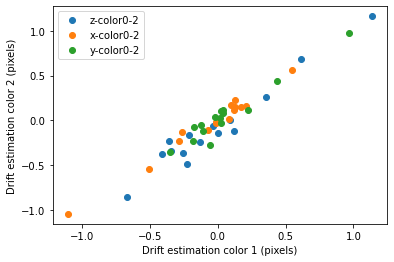

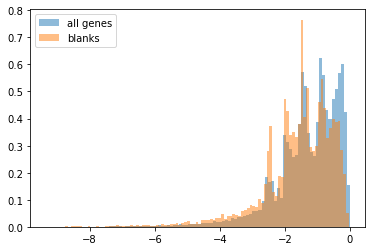

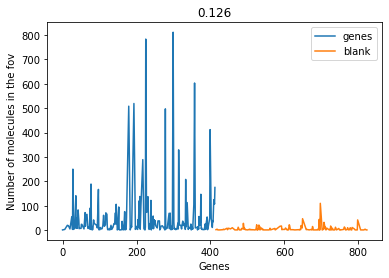

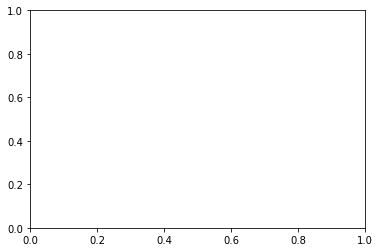

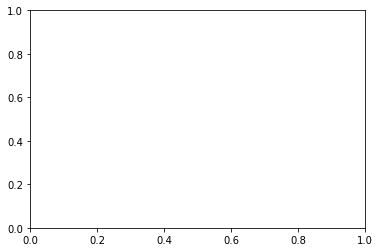

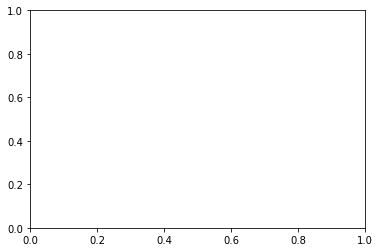

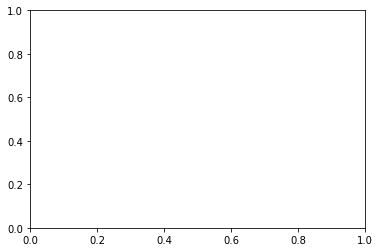

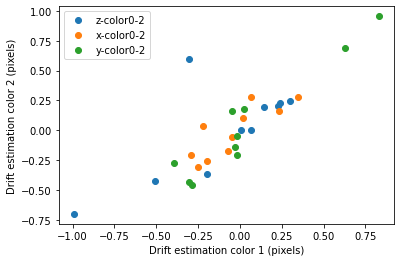

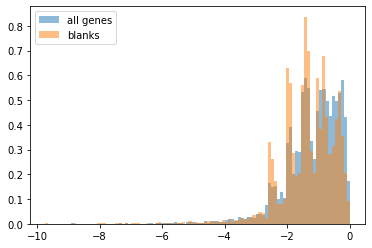

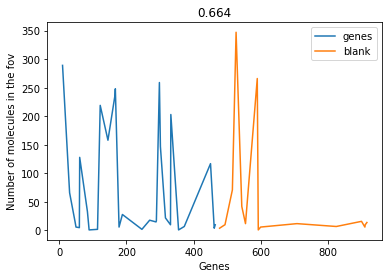

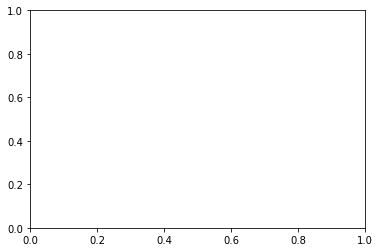

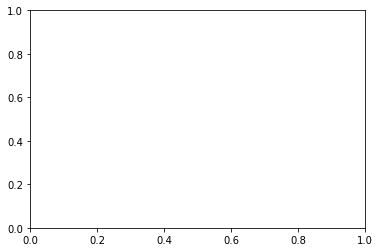

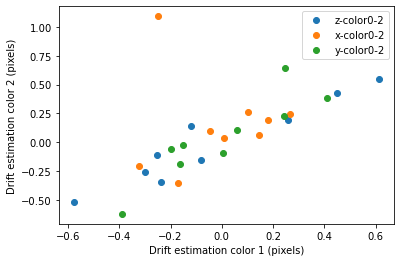

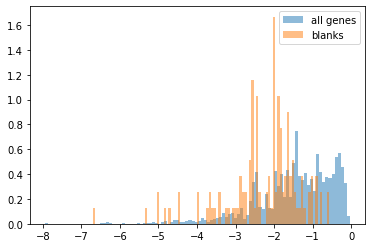

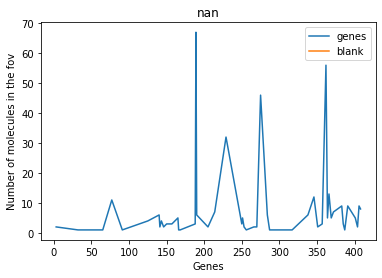

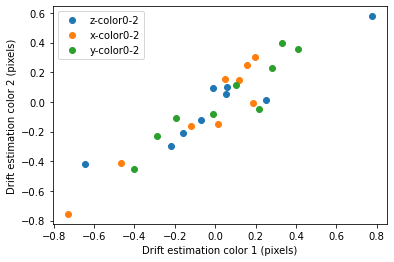

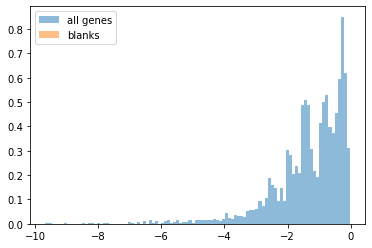

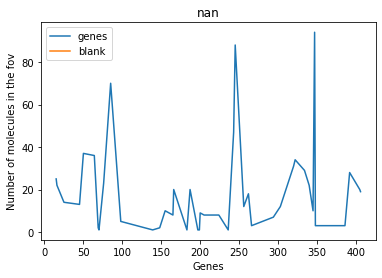

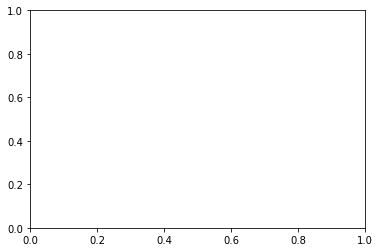

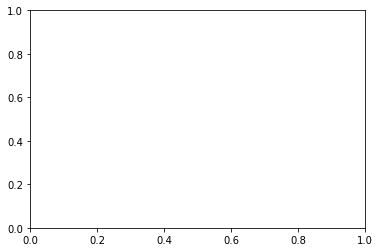

In [6]:
for fov,set_,save_folder in tqdm(paramaters[::-1]):
    try:
        main_analysisV1(fov,set_,
                       save_folder = save_folder,
                       save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                       save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                       drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                       segm_tag = 'A1_LamA_Nup98')
    except:
        print("Failed at:",fov,set_,save_folder)

### Load library information

In [1]:
import sys
sys.path.append(r'..//')
from ioMicro import *

In [2]:
tags_lib = ['-e1','-e2','-p12','-p34','-p56','-p711']
fls_lib = ['C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevEP1-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevEP2-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP1P2-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP3P4-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP5P6-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP7P11-code_color2__comb16-4-4.csv']
namesf = []
namesflib = []
for fl_l,tag_l in zip(fls_lib,tags_lib):
    dfL = pd.read_csv(fl_l)
    namesf+=[nm+tag_l if 'blank' in nm else nm for nm in dfL['name']]
    namesflib+=[nm+'--'+tag_l for nm in dfL['name']]
genesf = np.unique(namesf)
dic_nmlib_index = dict(zip(genesf,np.arange(len(genesf))))

dic_libs = {}
for gn in namesflib:
    gn_,lib_ = gn.split('---')[0],gn.split('---')[-1]
    if gn_ not in dic_libs: dic_libs[gn_]=[]
    dic_libs[gn_].append(lib_)


### Load the cell info first - fast

In [3]:
set_ = '_D7'
save_fls_ = glob.glob(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--*'+set_+'*')
len(save_fls_)

186

In [4]:
#dic_cells = {}
#dic_cells_alt={}
cells_all = None
keys = []
for save_fl in tqdm(save_fls_[:]):
    #save_fl = save_fls_[0]
    dic = np.load(save_fl)
    cells = dic['cellinfo'][1:]
    header_cells = list(dic['header_cells'])
   
    vols = cells[:,header_cells.index('volm')]

    icellsf = cells[:,0].astype(int)
    vols = cells[:,header_cells.index('volm')]
    
    vol_th_ = vols>4000
    icellsf = icellsf[vol_th_]
    cells = cells[vol_th_]
    base = os.path.basename(save_fl).split('--')[-2]+'_'
    keys.extend([base+str(int(cell)) for cell in cells[:,0]])
    cells_all = cells if cells_all is None else np.concatenate([cells_all,cells],axis=0)

    
volms = cells_all[:,1]
index = np.argsort(volms)[::1]
keys_ = np.array(keys)[index]
cells_all_=cells_all[index]
dice_cells = dict(zip(keys_,cells_all_))
keysF = np.array(list(dice_cells.keys()))
Xcells = np.array([dice_cells[cell][[0,-3,-2,-1]]for cell in keysF])

tree = cKDTree(Xcells)
res = tree.query_ball_tree(tree,20)
res_ = []
indCells = Xcells[:,0]

for ir,r in enumerate(tqdm(res)):
    ind_ = indCells[r]
    res_.append(np.array(r)[ind_==indCells[ir]])
dic_match={}
for ir,r in enumerate(res_):
    for r_ in r:
        dic_match[keysF[ir]]=keysF[r_]

100%|████████████████████████████████████████████████████████████████████████| 36696/36696 [00:00<00:00, 130959.58it/s]


### Load cell by gene in df

In [5]:
#df will be of size genesf and cellidsf
#cell_df,df=None,None
dfF = None
cell_dfF = None
counter=0
dic_cells = {}
cellidsf = []
df = np.zeros([0,len(genesf)])

for save_fl in tqdm(save_fls_[:]):
    #save_fl = save_fls_[0]
    dic = np.load(save_fl)
    XF = dic['XF']
    header = list(dic['header'])
    genes_decoded = dic['genes']
    cells = dic['cellinfo'][1:]
    header_cells = list(dic['header_cells'])
    ### Rethrehold based on score
    iscore = list(header).index('score')
    scoreA = XF[:,iscore]
    keep = scoreA>-0.5



    icell = header.index('cell_id')

    icells = XF[keep,icell].astype(int)
    vols = cells[:,header_cells.index('volm')]

    icellsf = cells[:,0].astype(int)
    vols = cells[:,header_cells.index('volm')]
    
    vol_th_ = vols>4000
    icellsf = icellsf[vol_th_]
    cells = cells[vol_th_]
    
    
    
    
    keep_vol = np.in1d(icells,icellsf) ### is molecule part of a big enough cell
    icells=icells[keep_vol] #final cell indexes of the molecules
    
    base_cell = os.path.basename(save_fl).split('--')[-2]+'_'
    icells_match = np.array([dic_match[base_cell+str(int(icell))]for icell in icells])
    
    ugns,gns_i = np.unique(genes_decoded[keep][keep_vol],return_inverse=True)
    
    
    
    icells_unique,icells_inv = np.unique(icells_match,return_inverse=True)
    #icells_unique = list(icells_unique)+list(np.setdiff1d(icellsf,icells_unique))### add back in the 0 count cells
    #icells_unique = np.array(icells_unique)
    mcell = len(icells_unique)#+1
    gn_cell,gn_cell_cts = np.unique(mcell*gns_i+icells_inv,return_counts=True)
    igns_ = gn_cell//mcell
    icells_ = gn_cell%mcell
    Mcts = np.zeros([mcell,len(ugns)])
    Mcts[icells_,igns_]=gn_cell_cts
    
    _,plate,fov,set_ = os.path.basename(save_fl).split('--')
    plate = plate.lower().split('analysis')[-1]
    ugns_ = [gn+'-'+plate if 'blank' in gn else gn for gn in ugns]
    igns = [dic_nmlib_index[gn] for gn in ugns_]
    
    #icells_unique
    in_common_cells = np.in1d(icells_unique,cellidsf)#,assume_unique=True)
    cellidsf_dic = dict(zip(cellidsf,np.arange(len(cellidsf))))
    in_common_cells_f = np.array([cellidsf_dic[cell_] for cell_ in icells_unique[in_common_cells]],dtype=int)
    #in_common_cells_f = np.in1d(cellidsf,icells_unique)#,assume_unique=True)
    vals = np.zeros([np.sum(in_common_cells),len(genesf)])
    prev_vals = df[in_common_cells_f][:,igns]
    vals[:,igns] = np.max([Mcts[in_common_cells],prev_vals],axis=0)
    if np.sum(in_common_cells_f)>0:
        df[in_common_cells_f] = np.max([vals,df[in_common_cells_f]],axis=0)
    
    #df[in_common_cells_f][:,igns] = np.max([df[in_common_cells_f][:,igns],Mcts[in_common_cells]],axis=0)
    not_in_common_cells = ~in_common_cells
    extra_df = np.zeros([np.sum(not_in_common_cells),len(genesf)])
    extra_df[:,igns]=Mcts[not_in_common_cells]
    df = np.concatenate([df,extra_df])
    cellidsf+=list(icells_unique[not_in_common_cells])
    

100%|████████████████████████████████████████████████████████████████████████████████| 186/186 [10:16<00:00,  3.31s/it]


### Save dataframes

In [6]:

print(len(cellidsf))
dff = pd.DataFrame(df,columns=genesf,index=cellidsf)
cell_df = np.array([dice_cells.get(cell,[0]*len(header_cells)) for cell in cellidsf])
cell_df = pd.DataFrame(cell_df,columns=header_cells,index=cellidsf)
dff.to_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\dff'+set_+'_0p5thV2.pkl')
cell_df.to_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\cell_df'+set_+'_0p5thV2.pkl')

25758


### Load and visiualize dataframes

In [9]:
import sys
sys.path.append(r'..//')
from ioMicro import *
import pandas as pd

In [10]:
dff = pd.read_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\dff_D16_0p5th.pkl')
cell_df = pd.read_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\cell_df_D16_0p5th.pkl')

In [27]:
def plot_gene_mosaic_cells(df,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20,viewer=None):
    cell_df_ = cell_df
    xcells,ycells=cell_df_['x_um_abs'],cell_df_['y_um_abs']
    Xcells = np.array([xcells*flipx,ycells*flipy][::transpose]).T
    vols = cell_df_['volm']
    
    cts = np.array(df[gene])#Ptbp1_smFISH
    cts[np.isnan(cts)]=0
    cts = cts/vols*np.median(vols)
    
    ncts = np.clip(cts/nmax,0,1)
    size = sz_min+ncts*(sz_max-sz_min)
    from matplotlib import cm as cmap
    cols = cmap.coolwarm(ncts)
    import napari
    good_cells = slice(None)
    good_cells = np.argsort(cts)
    names_cells = np.array(list(dff.index))[good_cells]
    XC = -Xcells[good_cells,::-1]
    if viewer is None:
        viewer = napari.view_points(XC,size=size[good_cells],face_color=cols[good_cells],name=gene)
    else:
        viewer.add_points(XC,size=size[good_cells],face_color=cols[good_cells],name=gene)
    if plt_fov:
        #ifovs = np.array(list(df.index),dtype=int)//10**5
        ifovs = [int(nm.split('_')[-2]) for nm in names_cells]
        ifov_unk = np.unique(ifovs)
        Xfov = np.array([np.mean(XC[ifovs==ifov],axis=0)for ifov in ifov_unk])
        features =  {'fov':ifov_unk}
        text = {
            'string': '{fov:.0f}',
            'size': 20,
            'color': 'gray',
            'translation': np.array([0, 0]),
        }
        viewer.add_points(Xfov,text=text,features=features,edge_width=0)
    return viewer

In [36]:
svfld =r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\images'
#gene = 'Aif1'
#viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20);
gene = 'P2ry12'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20)
gene = 'Csf1r'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
gene = 'Tmem119'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
gene = 'Cx3cr1'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
if False:
    im = viewer.screenshot(size=(5000,5000))
    viewer.close()
    cv2.imwrite(svfld+os.sep+gene+'_D16.png',im[:,:,[2,1,0,3]])

In [24]:
gns_all = np.sort([gn for gn in dff.columns if 'blank' not in gn])
print(list(gns_all))

['1110008P14Rik', '1500015O10Rik', '1810041L15Rik', '2310069B03Rik', '2610528A11Rik', '2900055J20Rik', '3110035E14Rik', '4833407H14Rik', '4930570B17Rik', '6330403K07Rik', '9630013A20Rik', 'A1cf', 'A230050P20Rik', 'A830009L08Rik', 'A930003A15Rik', 'Abca8a', 'Abcb1b', 'Abcb4', 'Abcg1', 'Abhd15', 'Abhd2', 'Abi3', 'Abi3bp', 'Acer3', 'Ache', 'Acsl3', 'Acta2', 'Actg1', 'Adamts1', 'Adamts5', 'Adamts9', 'Adamtsl4', 'Adarb2', 'Adcy1', 'Adcy2', 'Adcyap1', 'Adgra2', 'Adgrd1', 'Adgre1', 'Adgrl3', 'Adh1', 'Adora2a', 'Adora3', 'Afap1l2', 'Afp', 'Agpat2', 'Agrp', 'Agt', 'Ahcyl2', 'Ahi1', 'Ahnak', 'Aif1', 'Aif1l', 'Akain1', 'Alas2', 'Alb', 'Aldh1a1', 'Aldh1a2', 'Aldh1a7', 'Aldh1l1', 'Aldoa', 'Aldoc', 'Alox12', 'Alox5ap', 'Alx1', 'Alyref', 'Ambra1', 'Amd2', 'Amot', 'Amz1', 'Angpt1', 'Ank2', 'Ankk1', 'Ankrd11', 'Anks6', 'Anln', 'Anp32e', 'Anxa2', 'Anxa5', 'Aoah', 'Ap3s1', 'Apln', 'Apoa1', 'Apoa2', 'Apoc2', 'Apod', 'Apoe', 'Apoo', 'Aqp1', 'Aqp2', 'Aqp3', 'Aqp4', 'Aqp8', 'Arg1', 'Arhgap10', 'Arhgap27', 'A

In [37]:
len(gns_all)

2042

In [42]:
svfld =r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\images'
if not os.path.exists(svfld): os.makedirs(svfld)
    
gene = 'Acsl'
for gene in [gn for gn in gns_all if 'Foxj1' in gn]:
#for gene in ['Malat1', 'H19', 'Col1a1', 'Dpysl3', 'Meg3', 'Ptprs', 'Mapt', 'Dpysl2', 'Gnb1', 'Ywhae', 'Col3a1', 'Sox4', 'Nfix', 'Serpinh1', 'Sparc', 'Agt', 'Nedd4', 'Nnat', 'Ina', 'Xist', 'Uchl1', 'Islr2', 'Igfbpl1', 'Elavl3', 'Sdc3', 'Rab6b', 'Gpm6a', 'Cntf', 'Ndn', 'Csdc2']:
    viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20)
    im = viewer.screenshot(size=(5000,5000))
    viewer.close()
    cv2.imwrite(svfld+os.sep+gene+'_D16.png',im[:,:,[2,1,0,3]])

In [32]:
'Tmem119' in gns_all

True

In [ ]:
TMEM119